In [ ]:
import pandas as pd
import tensorflow
import os
import cv2
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization , LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import activations

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!ls "/gdrive/My Drive/Proj2_data/data1"

label_names.csv  test.pickle  train.pickle  valid.pickle


In [ ]:
train=pd.read_pickle('/gdrive/My Drive/Proj2_data/data1/train.pickle')
val = pd.read_pickle('/gdrive/My Drive/Proj2_data/data1/valid.pickle')
test = pd.read_pickle('/gdrive/My Drive/Proj2_data/data1/test.pickle')

In [ ]:
train['labels'][0]


41

In [ ]:
y_train = train['labels']
x_train = train['features']
y_val = val['labels']
x_val  = val['features']
testy =  test['labels']
testX = test['features']

In [ ]:
print(y_train.shape)

(34799,)


In [ ]:
signnames = pd.read_csv('/gdrive/My Drive/Proj2_data/data1/label_names.csv')
signnames
classID_signames = list(signnames['SignName'])

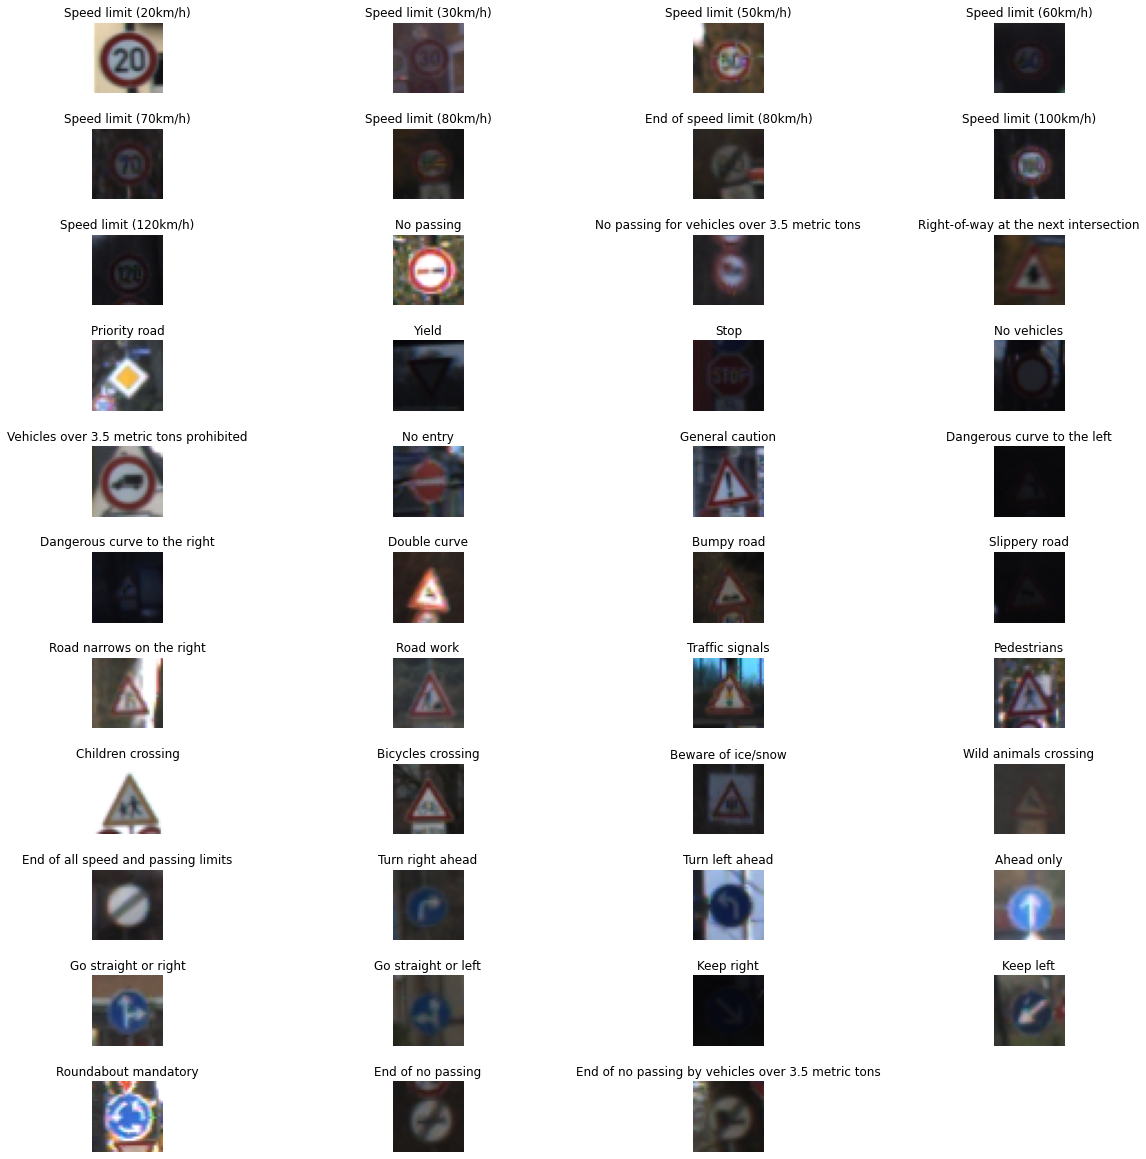

In [ ]:
#for Question 3
train_unique_indexs = list(np.unique(y_train , return_index=True)[1])
rows = len(train_unique_indexs)//4 + 1
f = plt.figure(figsize=(20, 16))
for i, index in enumerate(train_unique_indexs, 1):
    plt.subplot(rows, 4, i)
    plt.imshow(x_train[train_unique_indexs[i-1]])
    plt.axis('off')
    plt.title(classID_signames[i-1])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

In [ ]:
#for  Question 1 & 4 - Didnt work 

#datagen = ImageDataGenerator(  
#        rotation_range=30,   
#        zoom_range = 0.2,  
#        width_shift_range=0.2,  
#        height_shift_range=0.2,  
#        )
#cond = True  
#while(cond == True):
 #     augmented_data = []
 #     augmented_labels=[]
 #     num_augmented = 0
 #     batch = 100 # for 100*100 = 10000 entries
 #     for X_batch, y_batch in datagen.flow(trainX, y_train , batch_size=batch, shuffle=True,):
 #         for j in range (19):
  #            if(sign_count[y_batch[j]]<2010):
  #                augmented_data.append(X_batch)
  #                augmented_labels.append(y_batch)
  #                num_augmented += 1
      #            sign_count[y_batch[j]]= 100 + sign_count[y_batch[j]]
     #             if num_augmented == X_batch.shape[0]:
    #                  break
   #   if (augmented_data!=[]):
  #        augmented_data = np.concatenate(augmented_data) 
 #         augmented_labels = np.concatenate(augmented_labels)
#          trainX = np.concatenate((valX, augmented_data), axis = 0)
#          valy = np.concatenate((y_val , augmented_labels), axis = 0)
#      count=0
#      for i in range (43):
#          if(sign_count[i]<2010):
#              count=count+1
#      if (count==0):
#          cond == False

In [ ]:
#for Question 1
sign_count=[]
for i in range(43):
    sign_count.append(0)
    for j in range(len(y_train)):
        if(i == y_train[j]):
            sign_count[i]+=1
print("max :",max(sign_count))
print("min :",min(sign_count))

max : 2010
min : 180


In [ ]:
#for Question 1
trains = {}
for i in range(len(signnames)):
    trains[str(i)] = []

for i, image in enumerate(x_train):
    trains[str(y_train[i])].append(image)

In [ ]:
#for Question 1
for name , images in trains.items():
    length = len(images)
    while length<2010:
        trains[name] = np.concatenate((trains[name], images), axis=0)
        length+=len(images)
    np.random.shuffle(trains[name])
    trains[name] = np.array(trains[name][:2010])

In [ ]:
#for Question 1
trainX = []
trainy = []
for name, images in trains.items():
    trainX = trainX + images.tolist()
    trainy = trainy + [float(name) for i in range(2010)]

trainX = np.array(trainX)
trainy = np.array(trainy)

In [ ]:
print(trainX.shape)
print(trainy.shape)

(86430, 32, 32, 3)
(86430,)


In [ ]:
trainy[25128]

12.0

In [ ]:
#for Question 1
sign_count1=[]
for i in range(43):
    sign_count1.append(0)
    for j in range(len(y_val)):
        if(i == y_val[j]):
            sign_count1[i]+=1
print("max is  :",max(sign_count1))
print("min is :",min(sign_count1))

max is  : 240
min is : 30


In [ ]:
#for Question 1
vals = {}
for i in range(len(signnames)):
    vals[str(i)] = []

for i, img in enumerate(x_val):
    vals[str(y_val[i])].append(img)


In [ ]:
#for Question 1
for name , images in vals.items():
    length = len(images)
    while length<240:
        vals[name] = np.concatenate((vals[name], images), axis=0)
        length+=len(images)
    np.random.shuffle(vals[name])
    vals[name] = np.array(vals[name][:240])

In [ ]:
#for Question 1
valX = []
valy = []
for name, images in vals.items():
    valX = valX + images.tolist()
    valy = valy + [float(name) for i in range(240)]

valX = np.array(valX)
valy = np.array(valy)
print(valX.shape)
print(valy.shape)

(10320, 32, 32, 3)
(10320,)


In [ ]:
trainX = trainX.astype('float32')
valX = valX.astype('float32')

In [ ]:
#for Question 2 & 3
import cv2
arr = []
for i in trainX:
  pic = cv2.cvtColor(i , cv2.COLOR_RGB2GRAY)
  eq = cv2.equalizeHist(np.uint8(pic))
  arr.append(eq.reshape(32,32,1))
  
trainX = np.array(arr)  
# normalize to range 0-1
trainX = trainX / 255.0


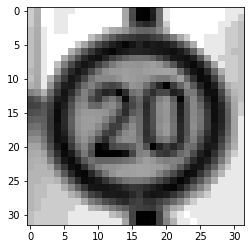

In [ ]:
plt.imshow(trainX[255].reshape(32,32),cmap='gray')

In [ ]:
#for Question 2 & 3
arr2 = []
for i in valX:
  pic = cv2.cvtColor(i , cv2.COLOR_RGB2GRAY)
  eq = cv2.equalizeHist(np.uint8(pic))
  arr2.append(eq.reshape(32,32,1))
  
valX = np.array(arr2)  
# normalize to range 0-1
valX = valX / 255.0


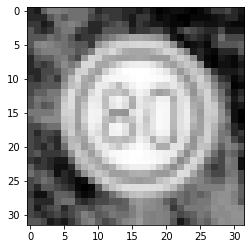

In [ ]:
plt.imshow(valX[1200].reshape(32,32),cmap='gray')

In [ ]:
trainy = to_categorical(trainy)
valy = to_categorical(valy)

In [ ]:
trainy.shape

(86430, 43)

In [ ]:
#for Question 4

datagen = ImageDataGenerator(  
        rotation_range=30,   
        zoom_range = 0.2,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        )  

augmented_data = []
augmented_labels=[]
num_augmented = 0
for X_batch, y_batch in datagen.flow(trainX, trainy, batch_size=100, shuffle=True):
    augmented_data.append(X_batch)
    augmented_labels.append(y_batch)
    num_augmented += 1
    if num_augmented == X_batch.shape[0]:
        break
augmented_data = np.concatenate(augmented_data) 
augmented_labels = np.concatenate(augmented_labels)


In [ ]:
trainX = np.concatenate((trainX, augmented_data), axis = 0)
trainy = np.concatenate((trainy , augmented_labels), axis = 0)

In [ ]:
trainX.shape

(96430, 32, 32, 1)

In [ ]:
#for Question 4

datagen = ImageDataGenerator(  
        rotation_range=30,   
        zoom_range = 0.2,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        )  

augmented_data = []
augmented_labels=[]
num_augmented = 0
for X_batch, y_batch in datagen.flow(valX, valy, batch_size=50, shuffle=True):
    augmented_data.append(X_batch)
    augmented_labels.append(y_batch)
    num_augmented += 1
    if num_augmented == X_batch.shape[0]:
        break
augmented_data = np.concatenate(augmented_data) 
augmented_labels = np.concatenate(augmented_labels)


In [ ]:
valX = np.concatenate((valX, augmented_data), axis = 0)
valy = np.concatenate((valy , augmented_labels), axis = 0)

In [ ]:
valX.shape

(12820, 32, 32, 1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
batch_size = 256
Training_data = datagen.flow(trainX,
                             y=trainy,
                            batch_size = batch_size)
Validation_data = datagen.flow(valX,
                             y=valy,
                            batch_size = batch_size)



In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
input_model = Input((trainX.shape[1],trainX.shape[2],trainX.shape[3]),name = 'input_layer')

model1 = Conv2D(64,(3,3), strides=(2,2) ,name = 'Conv1')(input_model)
model1 = BatchNormalization( name = 'Bnorm1')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)

model1 = Conv2D(64,(1,1) , name = 'Conv2')(model1)
model1 = Conv2D(64,(1,1) , padding='same',name= 'Conv3')(model1)
model1 = BatchNormalization(name = 'Bnorm2')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)

model1 = Conv2D(128,(3,3), strides=(2,2) ,name = 'Conv4')(model1)
model1 = BatchNormalization(name = 'Bnorm3')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)
model1 = Conv2D(128,(1,1) , padding='same',name= 'Conv5')(model1)
model1 = BatchNormalization(name = 'Bnorm4')(model1)

model1 = Conv2D(128,(1,1) , name = 'Conv6')(model1)
model1 = Conv2D(128,(1,1), padding='same',name= 'Conv7')(model1)
model1 = BatchNormalization(name = 'Bnorm5')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)

model1 = Conv2D(512,(3,3), strides=(2,2) ,name = 'Conv8')(model1)
model1 = BatchNormalization(name = 'Bnorm6')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)
model1 = Conv2D(512,(1,1), padding='same',name= 'Conv9')(model1)
model1 = BatchNormalization(name = 'Bnorm7')(model1)

model1 = Conv2D(512,(1,1) , name = 'Conv10')(model1)
model1 = Conv2D(512,(1,1), padding='same',name= 'Conv11')(model1)
model1 = BatchNormalization(name = 'Bnorm8')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)
model1 = Conv2D(1024,(3,3), strides=(2,2) ,name = 'Conv12')(model1)
model1 = BatchNormalization(name = 'Bnorm9')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)
model1 = Conv2D(1024,(1,1)  , padding='same',name= 'Conv13')(model1)
model1 = BatchNormalization(name = 'Bnorm10')(model1)

model1 = Conv2D(1024,(1,1)  , name = 'Conv14')(model1)
model1 = Conv2D(1024,(1,1), padding='same',name= 'Conv15')(model1)
model1 = BatchNormalization(name = 'Bnorm11')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)

model1 = Conv2D(128,(1,1), activation='relu',name = 'Conv16')(model1)
model1 = BatchNormalization(name = 'Bnorm12')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)
model1 = Conv2D(128,(1,1), padding='same',name= 'Conv17')(model1)
model1 = BatchNormalization(name = 'Bnorm13')(model1)
model1 = LeakyReLU(alpha=0.1)(model1)


model1 = AveragePooling2D((1, 1),name = 'AvgPool1')(model1)

#model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
#model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv3_3')(model1)
#model1 = BatchNormalization(name = 'Bnorm3')(model1)
#model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv4_3')(model1)
#model1 = BatchNormalization(name = 'Bnorm4')(model1)
#model1 = AveragePooling2D((2, 2),name = 'AvgPool1')(model1)
#model1 = Conv2D(128,(1,1), activation='relu' ,padding='valid',name = 'Conv5_1')(model1)
#model1 = BatchNormalization(name = 'Bnorm5')(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
model1 = Dropout(rate = 0.25)(model1)
model1 = Dense(units = 512, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
#model1 = Dropout(rate = 0.5)(model1)
#model1 = Dense(units = 32, activation = 'relu')(model1)
#model1 = BatchNormalization()(model1)
#model1 = Dense(units = 64, activation = 'relu')(model1)
#model1 = BatchNormalization()(model1)
output = Dense(units = 43, activation = 'softmax' , name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 15, 15, 64)        640       
_________________________________________________________________
Bnorm1 (BatchNormalization)  (None, 15, 15, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 15, 15, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 15, 15, 64)        4160      
_________________________________________________________________
Conv3 (Conv2D)               (None, 15, 15, 64)        4160      
_________________________________________________________________
Bnorm2 (BatchNormalization)  (None, 15, 15, 64)       

In [ ]:
sgd = SGD(lr=0.01, momentum=0.9)
adam= tensorflow.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(Training_data, 
                              validation_data= Validation_data ,
                              verbose=1,
                              batch_size = 128,
                              shuffle = True,
                              epochs= 15,
                              callbacks=[es , checkpointer ])

Epoch 1/15
377/377 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9685
Epoch 00001: val_accuracy did not improve from 0.85975
377/377 [==============================] - 35s 94ms/step - loss: 0.1030 - accuracy: 0.9685 - val_loss: 0.5680 - val_accuracy: 0.8404
Epoch 2/15
377/377 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9719
Epoch 00002: val_accuracy did not improve from 0.85975
377/377 [==============================] - 35s 92ms/step - loss: 0.0922 - accuracy: 0.9719 - val_loss: 0.5766 - val_accuracy: 0.8568
Epoch 00002: early stopping


In [ ]:
model.save_weights("/gdrive/My Drive/2networkWEIGHT.hdf5")
model.save("/gdrive/My Drive/2networkMODEL.hdf5")

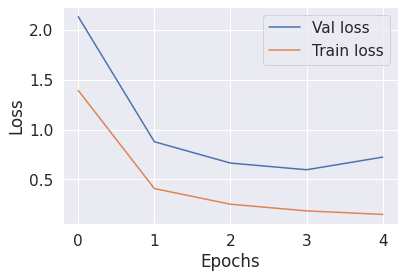

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val loss','Train loss'], loc='upper right')
plt.savefig('plotloss.png')
plt.show()

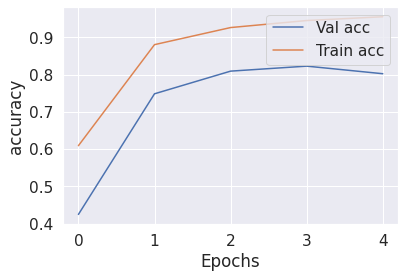

In [ ]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val acc','Train acc'], loc='upper right')
plt.savefig('plot_accuracy.png')
plt.show()

In [ ]:
testX = test['features']
testX = testX.astype('float32')
arr3 = []
for i in testX:
  pic = cv2.cvtColor(i , cv2.COLOR_RGB2GRAY)
  eq = cv2.equalizeHist(np.uint8(pic))
  arr3.append(eq.reshape(32,32,1))
  
testX = np.array(arr3)  
testX = testX / 255.0
test
testX.shape

(12630, 32, 32, 1)

In [ ]:
testy = to_categorical(testy)

In [ ]:
testy[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y_test_predict = model.predict(testX)
test_score = len(testy[testy.argmax(axis=1)==y_test_predict.argmax(axis=1)])/len(testy)
print(f"Test Score = {test_score*100:0.2f}%")

Test Score = 90.33%


In [ ]:
classID_signames[0]

'Speed limit (20km/h)'

In [ ]:
testy.argmax(axis=1)[0]

16

In [ ]:
for i in range (len(testy)):
    if (testy.argmax(axis=1)[i]!=y_test_predict.argmax(axis=1)[i]):
        print(classID_signames[testy.argmax(axis=1)[i]]
        + " instead of "
        + classID_signames[y_test_predict.argmax(axis=1)[i]])

Speed limit (80km/h) instead of Speed limit (60km/h)
Speed limit (120km/h) instead of Speed limit (70km/h)
Beware of ice/snow instead of Slippery road
General caution instead of Road work
Road work instead of Traffic signals
Speed limit (80km/h) instead of Speed limit (60km/h)
Beware of ice/snow instead of Right-of-way at the next intersection
Double curve instead of Dangerous curve to the left
Beware of ice/snow instead of Pedestrians
Beware of ice/snow instead of Bumpy road
End of speed limit (80km/h) instead of End of no passing by vehicles over 3.5 metric tons
Road work instead of Traffic signals
Road work instead of Pedestrians
No entry instead of Priority road
No passing for vehicles over 3.5 metric tons instead of Dangerous curve to the right
General caution instead of Pedestrians
Speed limit (80km/h) instead of Speed limit (50km/h)
Speed limit (80km/h) instead of Speed limit (60km/h)
Go straight or right instead of Ahead only
Beware of ice/snow instead of Ahead only
Speed limit

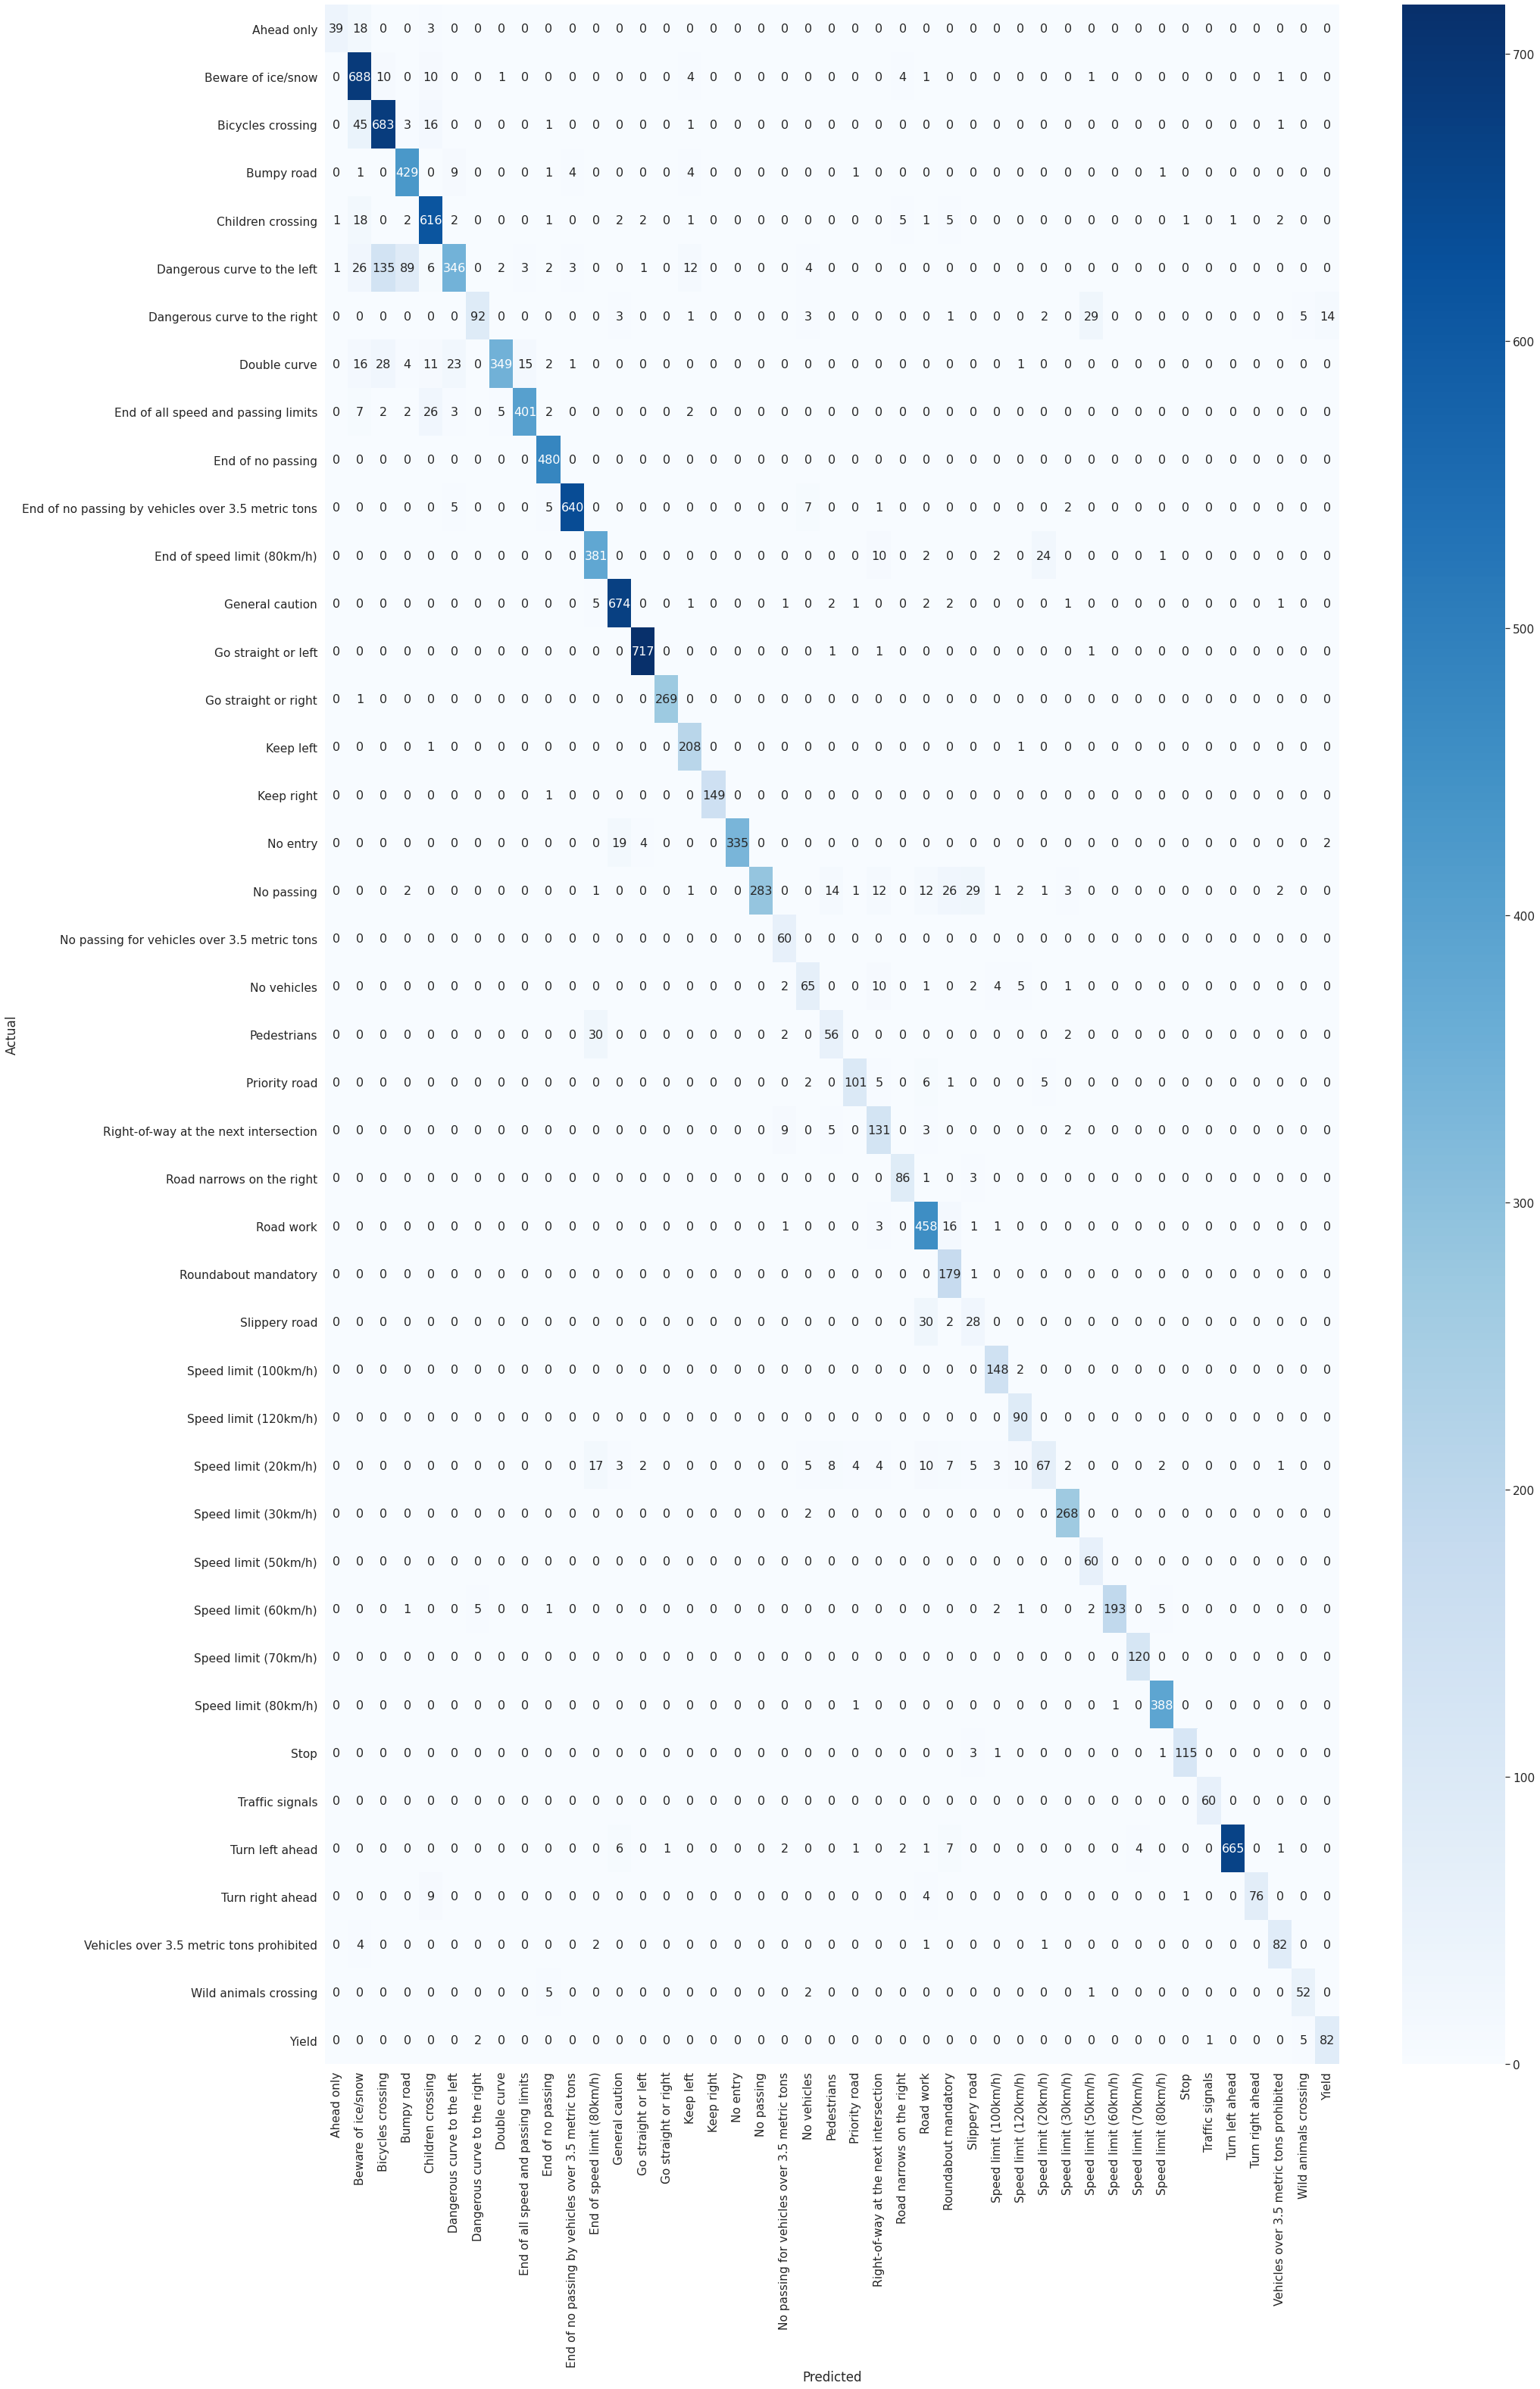

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_true = classID_signames
y_pred = classID_signames
data = confusion_matrix(testy.argmax(axis=1), y_test_predict.argmax(axis=1))
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,50))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size

In [ ]:
layer_names = []
for layer in model.layers[1:43]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

layer_names

['Conv1',
 'Bnorm1',
 'leaky_re_lu',
 'Conv2',
 'Conv3',
 'Bnorm2',
 'leaky_re_lu_1',
 'Conv4',
 'Bnorm3',
 'leaky_re_lu_2',
 'Conv5',
 'Bnorm4',
 'Conv6',
 'Conv7',
 'Bnorm5',
 'leaky_re_lu_3',
 'Conv8',
 'Bnorm6',
 'leaky_re_lu_4',
 'Conv9',
 'Bnorm7',
 'Conv10',
 'Conv11',
 'Bnorm8',
 'leaky_re_lu_5',
 'Conv12',
 'Bnorm9',
 'leaky_re_lu_6',
 'Conv13',
 'Bnorm10',
 'Conv14',
 'Conv15',
 'Bnorm11',
 'leaky_re_lu_7',
 'Conv16',
 'Bnorm12',
 'leaky_re_lu_8',
 'Conv17',
 'Bnorm13',
 'leaky_re_lu_9',
 'AvgPool1',
 'Flatten']

layer : Conv1 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


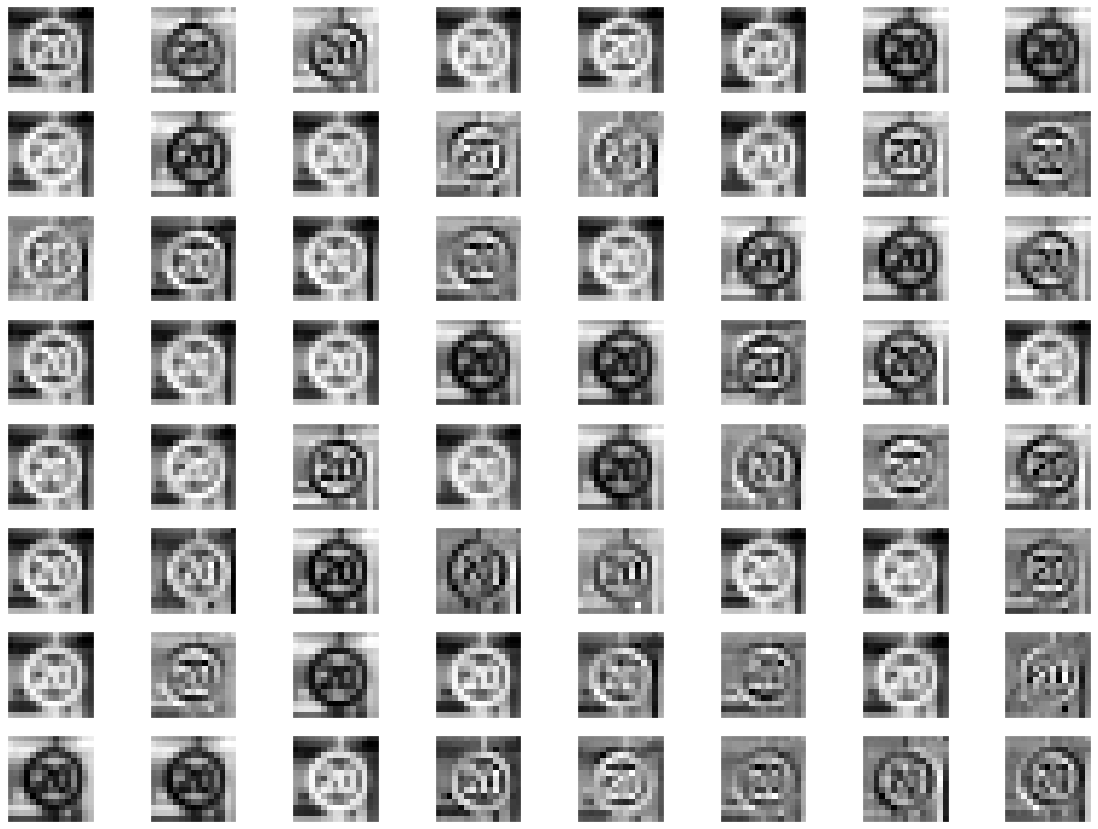

layer : Bnorm1 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


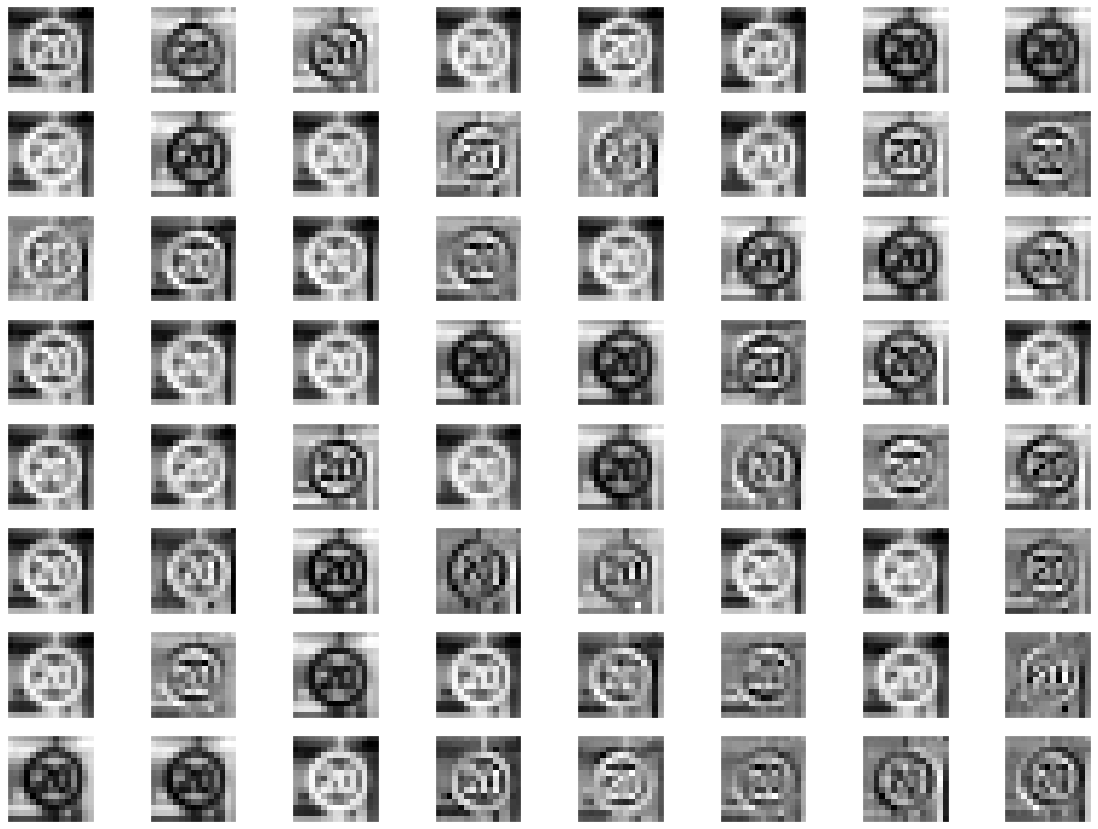

layer : leaky_re_lu_22 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


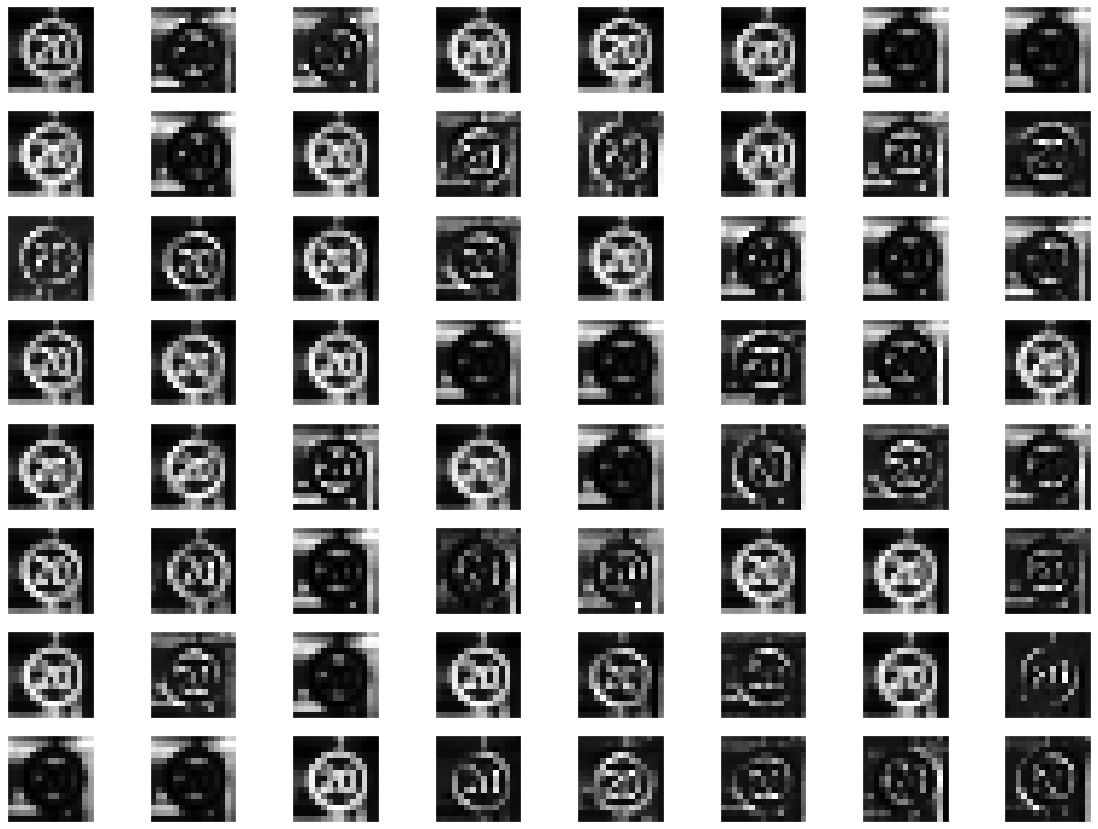

layer : Conv2 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


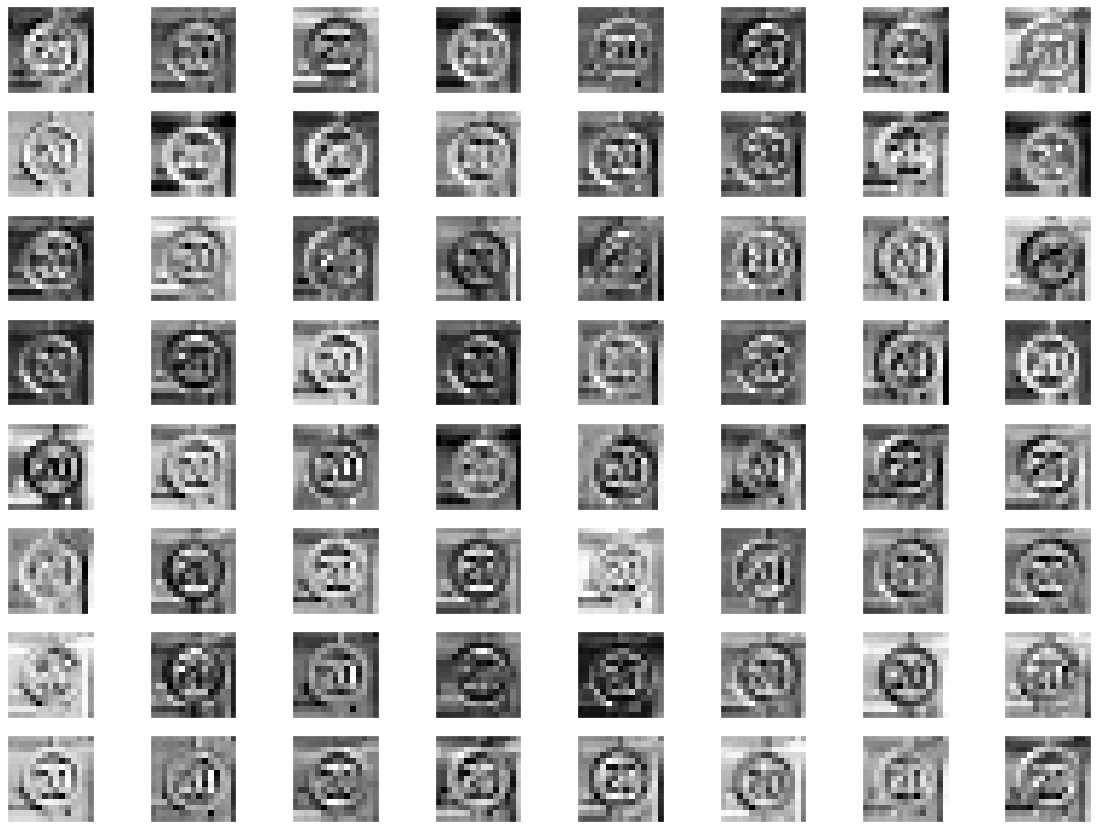

layer : Conv3 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


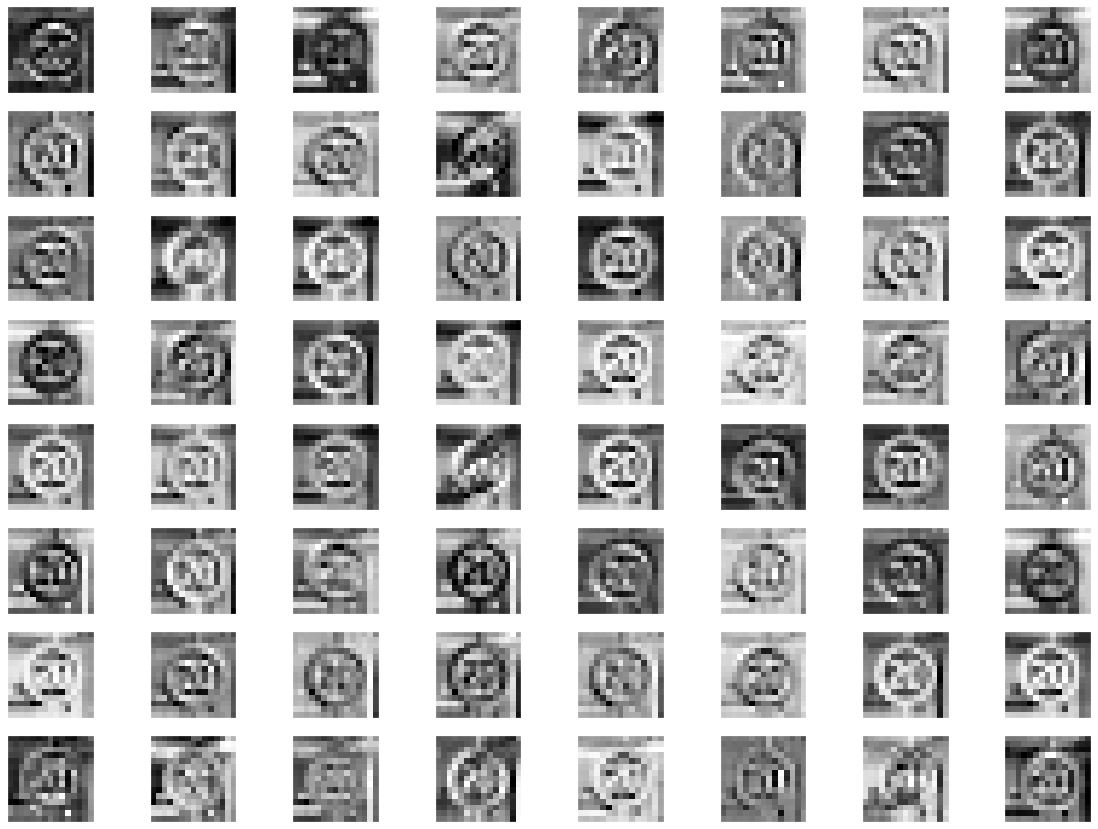

layer : Bnorm2 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


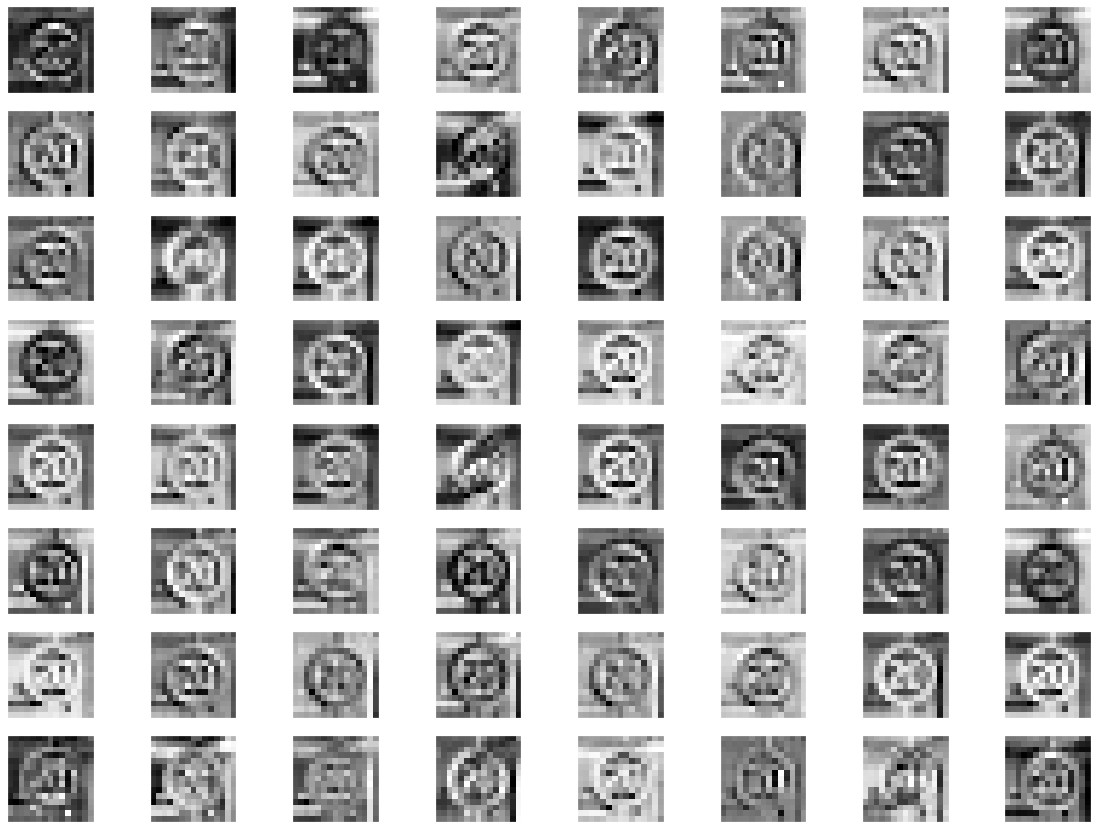

layer : leaky_re_lu_23 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


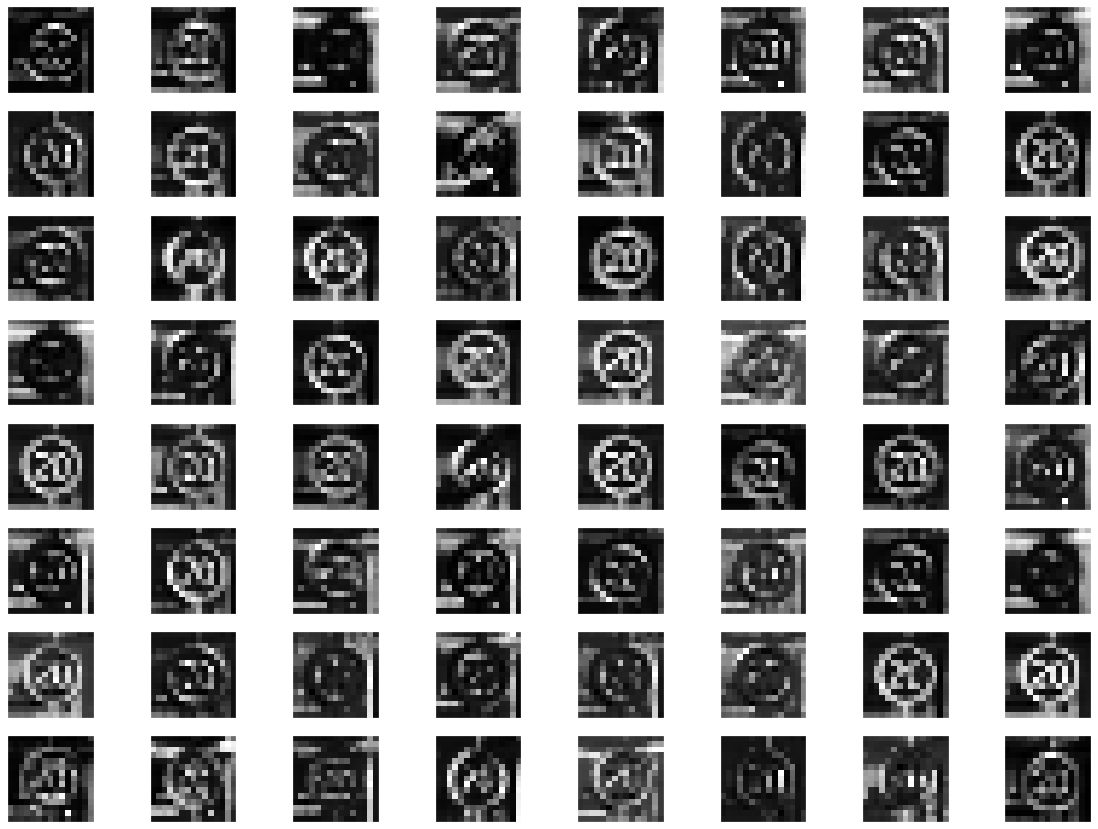

layer : Conv4 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


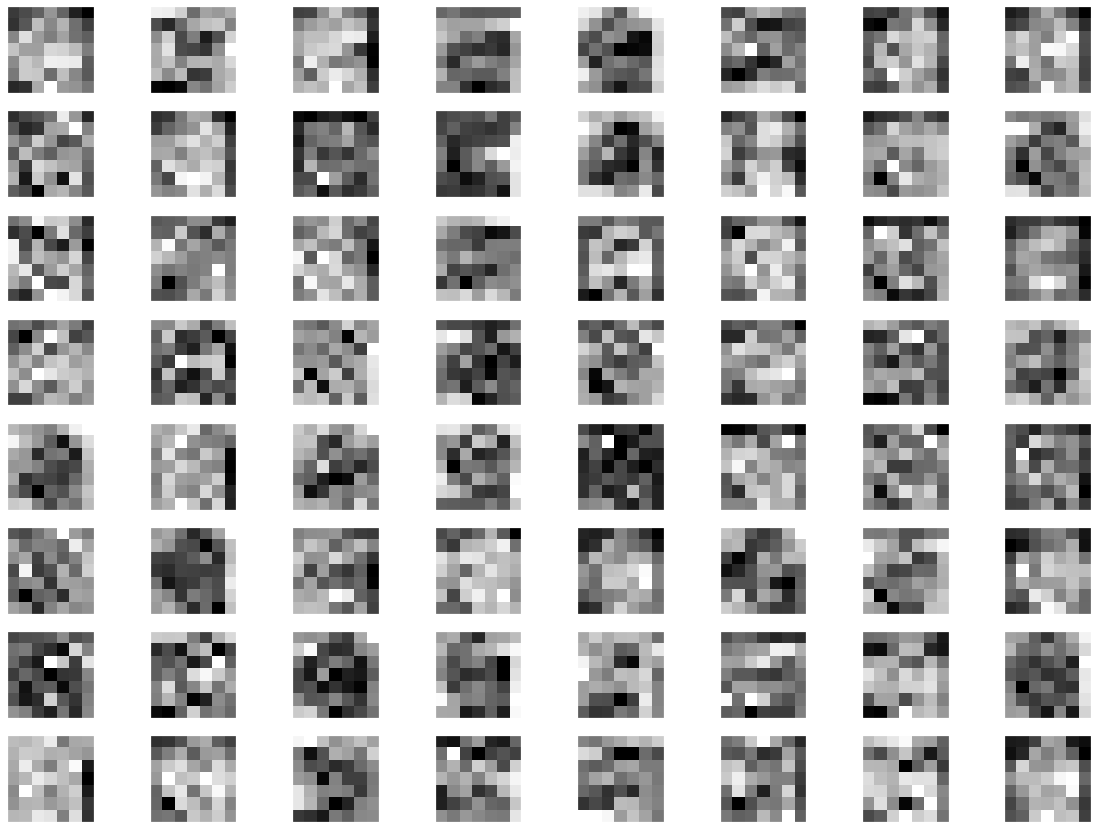

layer : Bnorm3 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


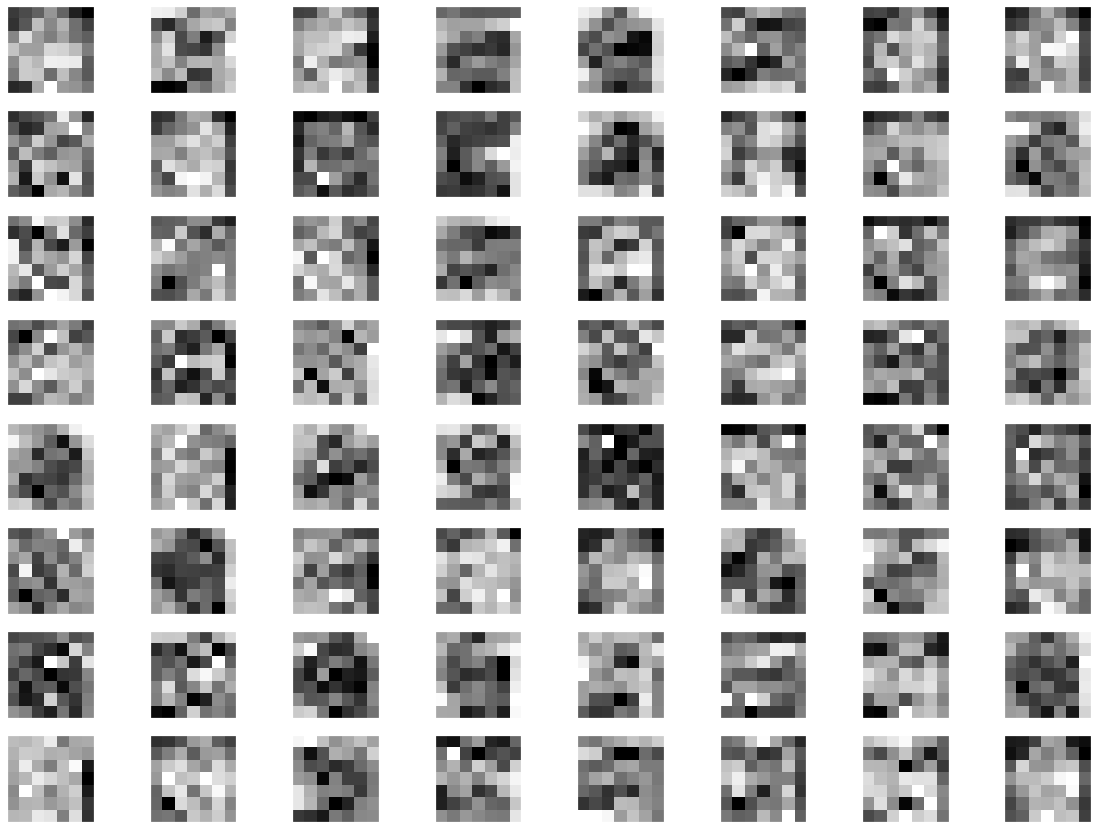

layer : leaky_re_lu_24 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


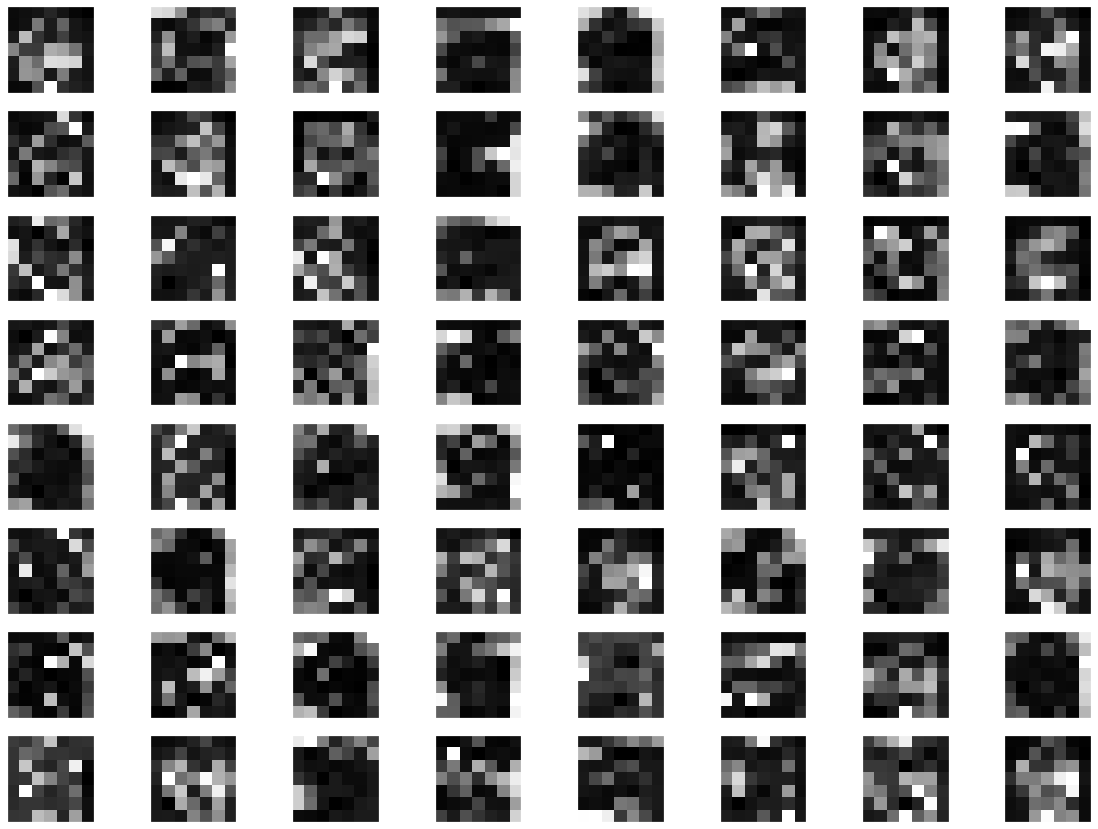

layer : Conv5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


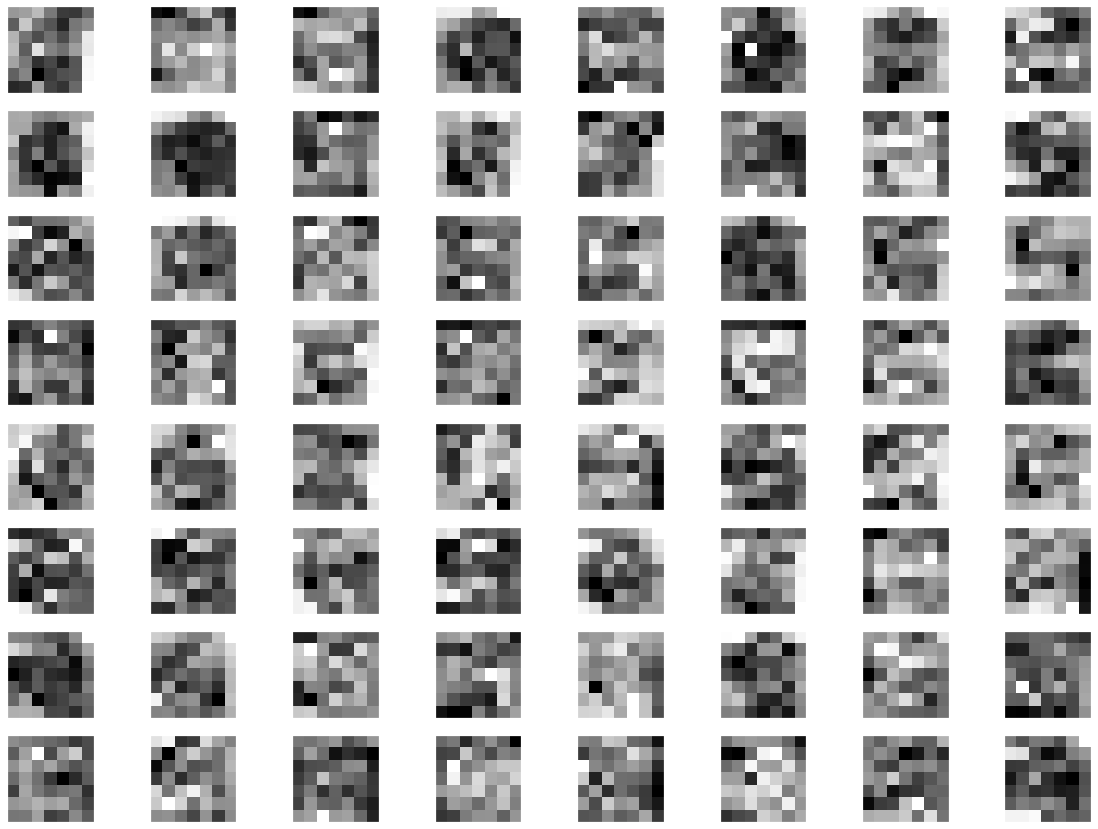

layer : Bnorm4 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


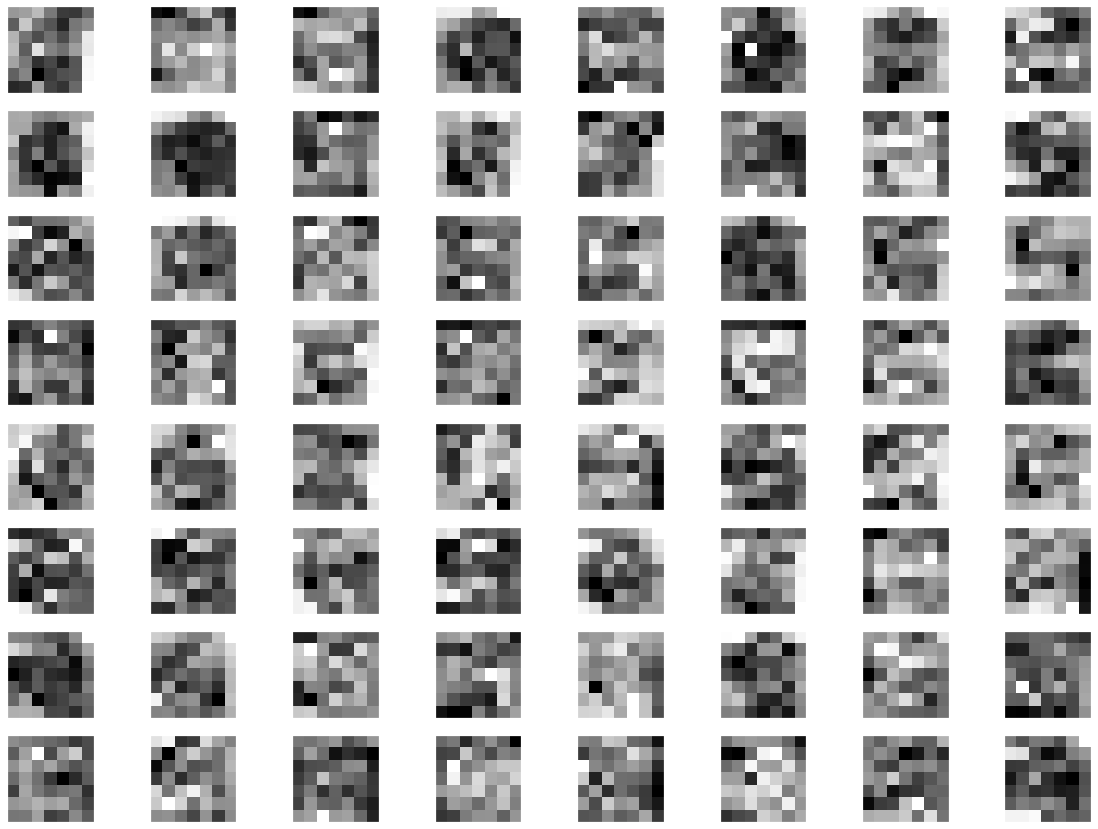

layer : Conv6 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


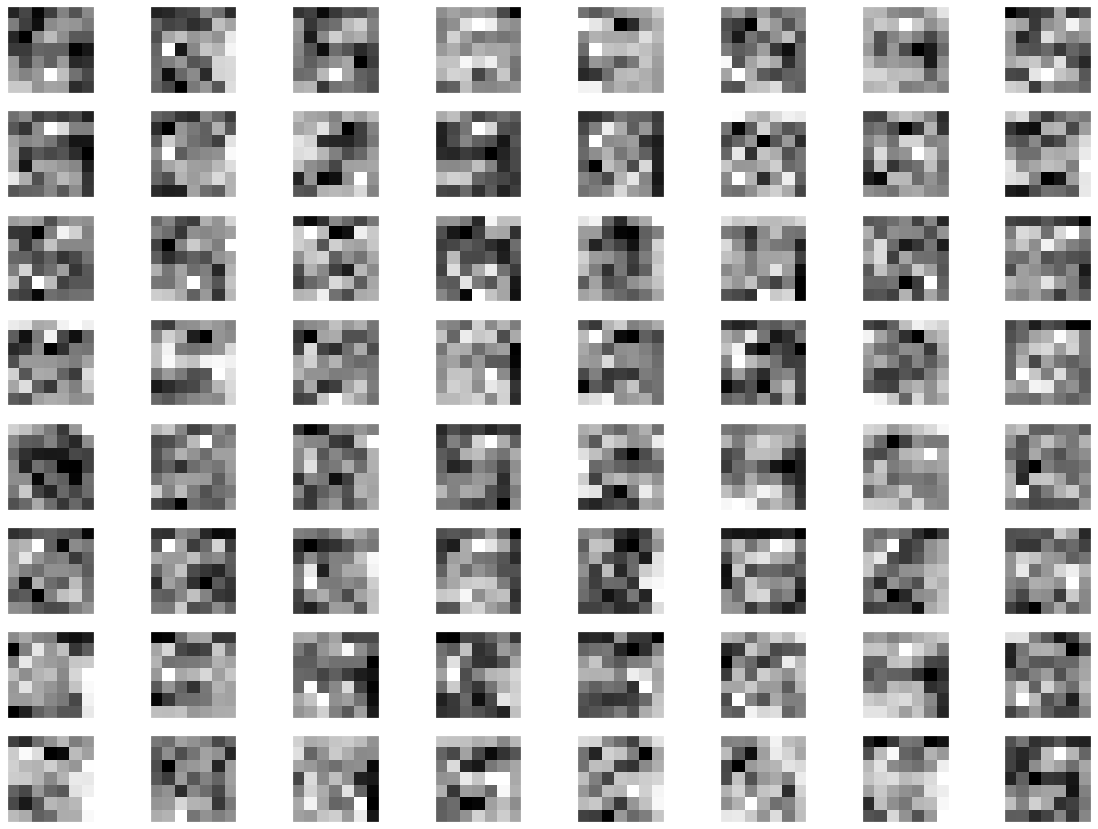

layer : Conv7 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


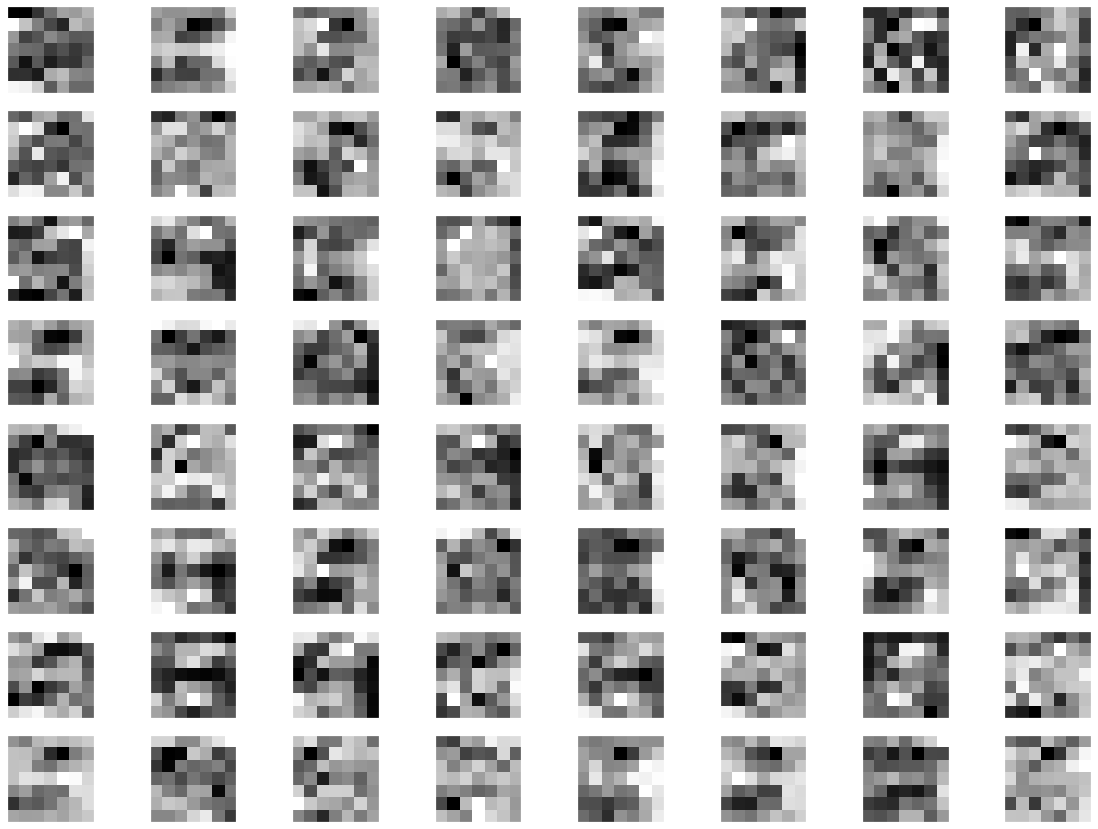

layer : Bnorm5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


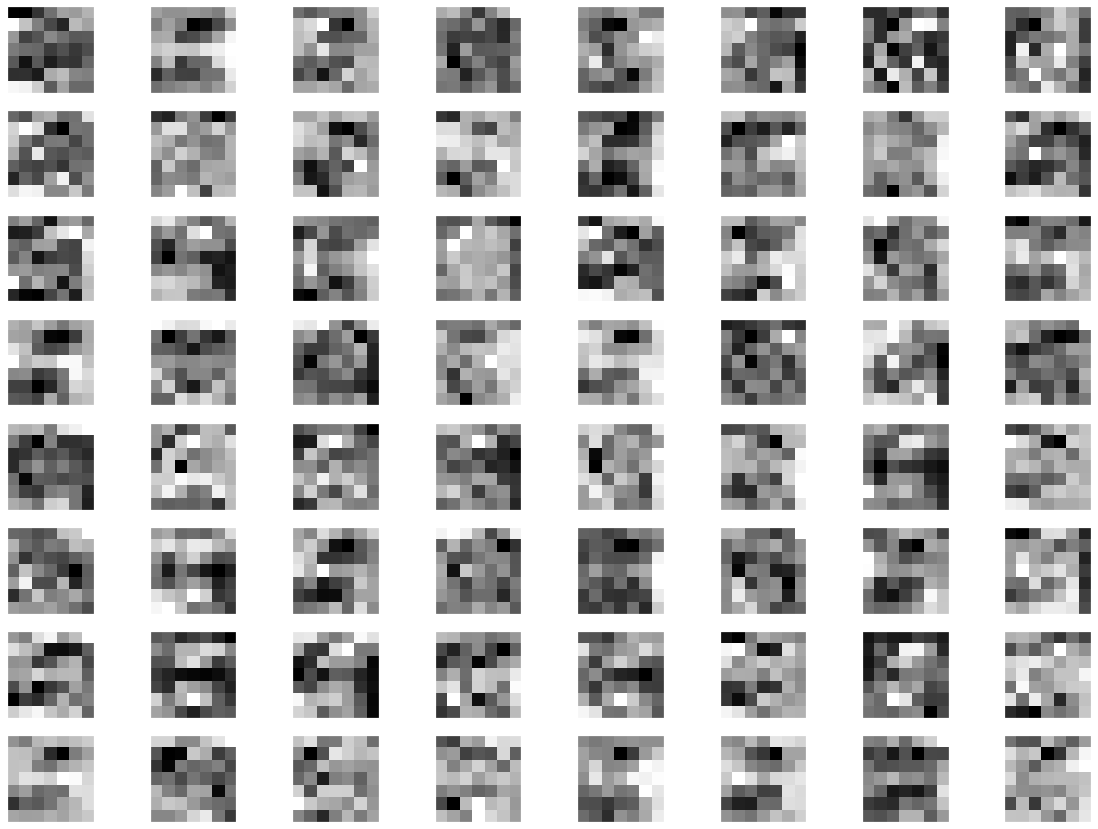

layer : leaky_re_lu_25 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


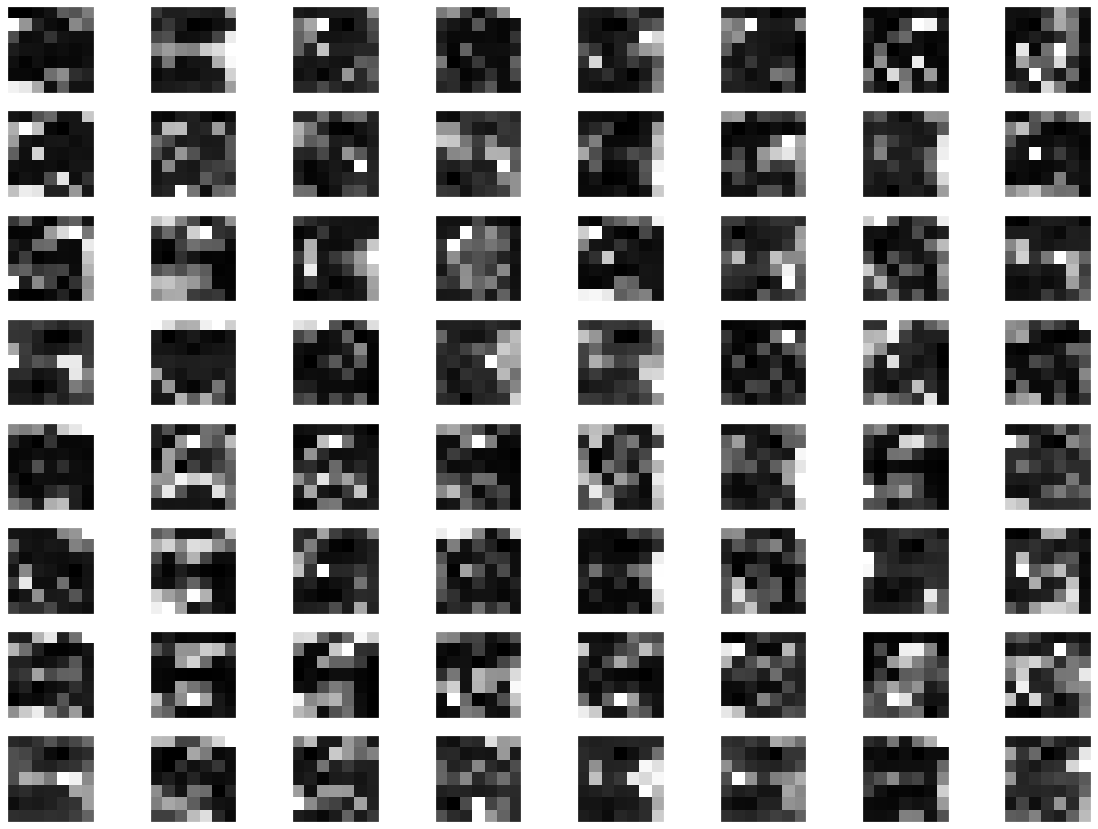

layer : Conv8 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


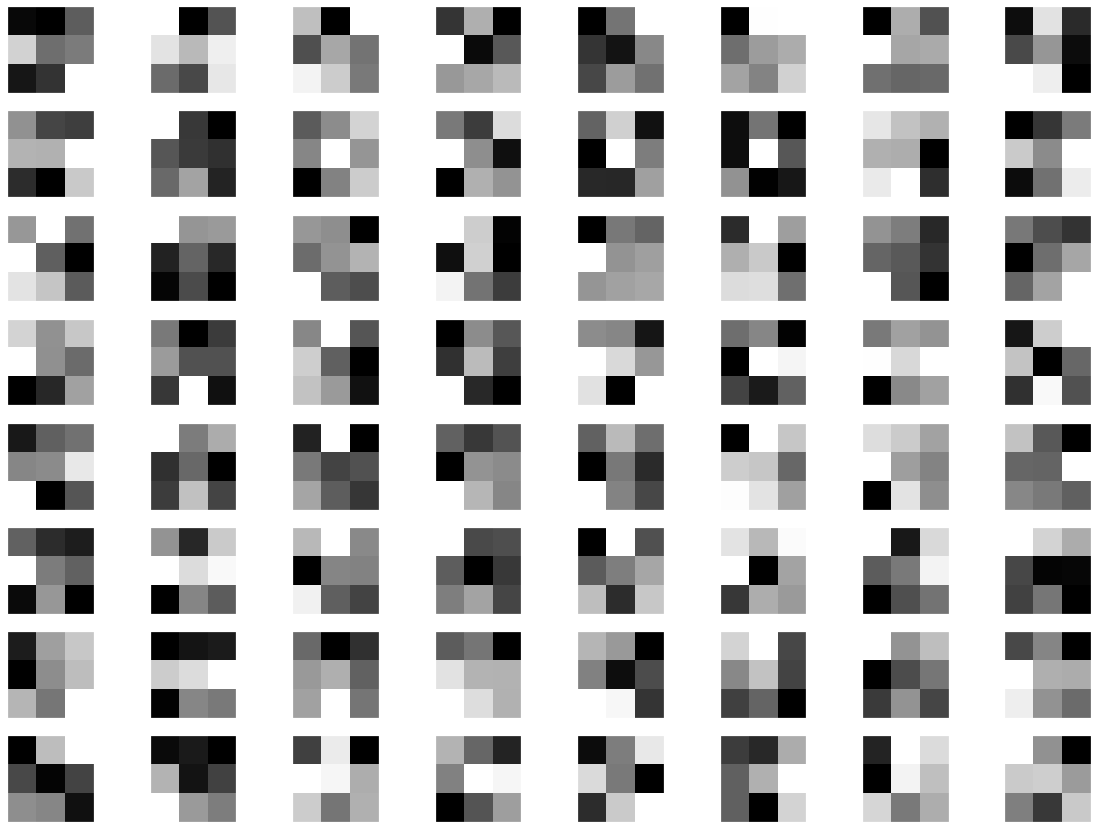

layer : Bnorm6 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


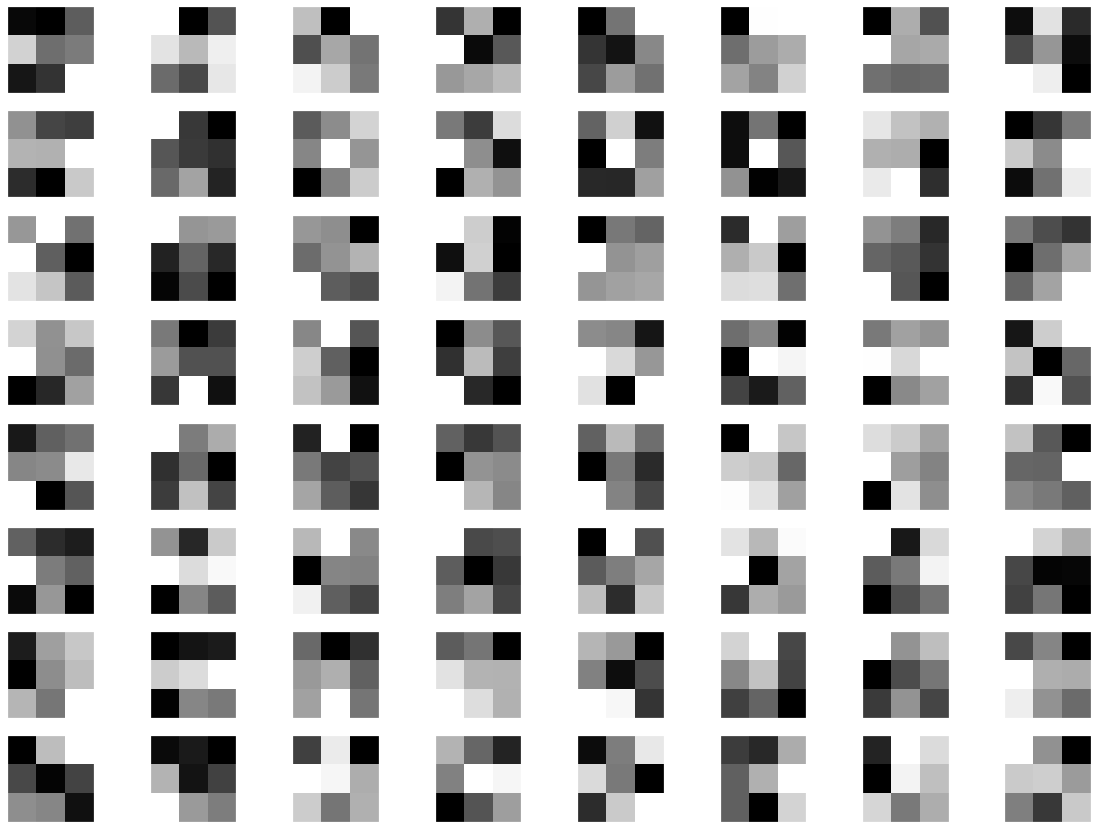

layer : leaky_re_lu_26 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


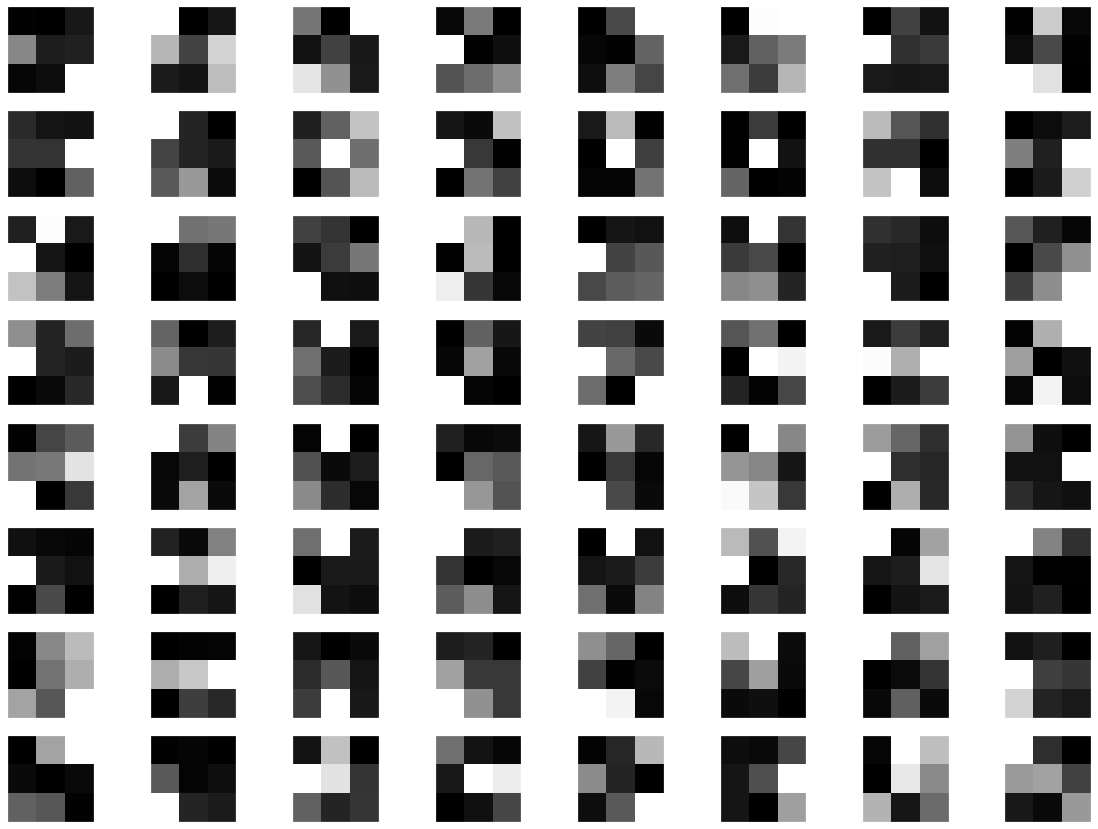

layer : Conv9 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


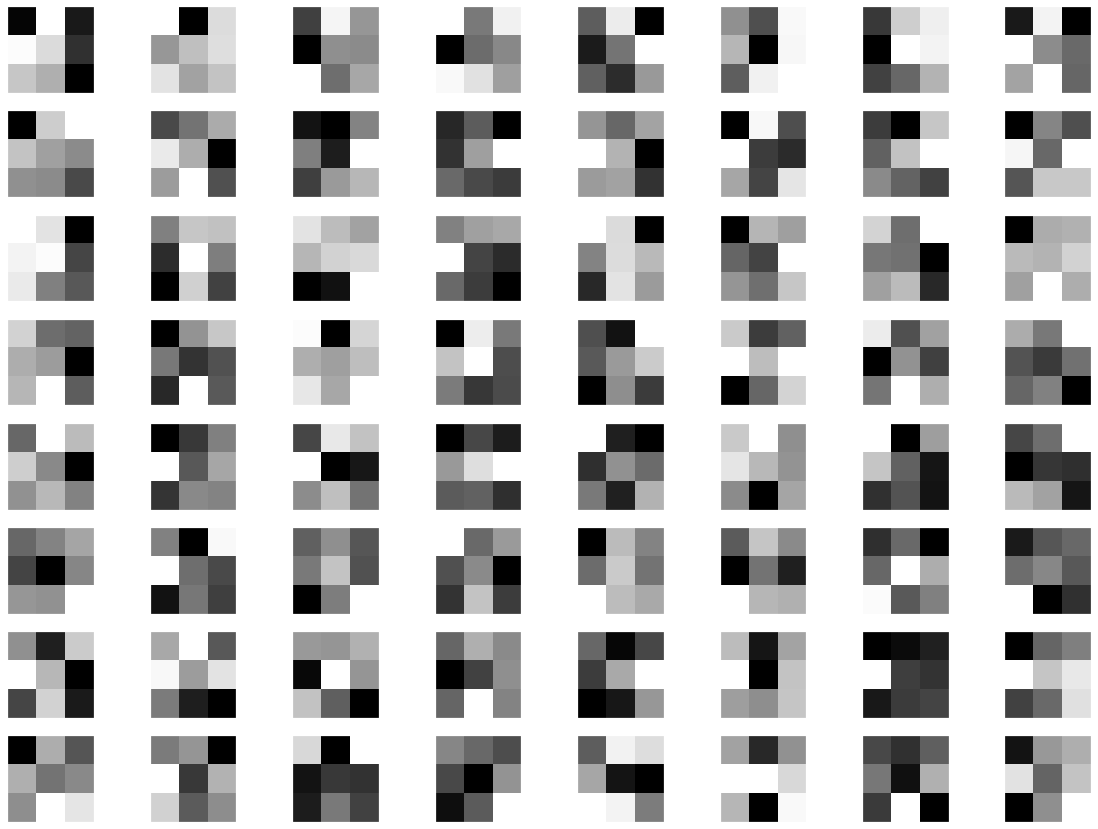

layer : Bnorm7 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


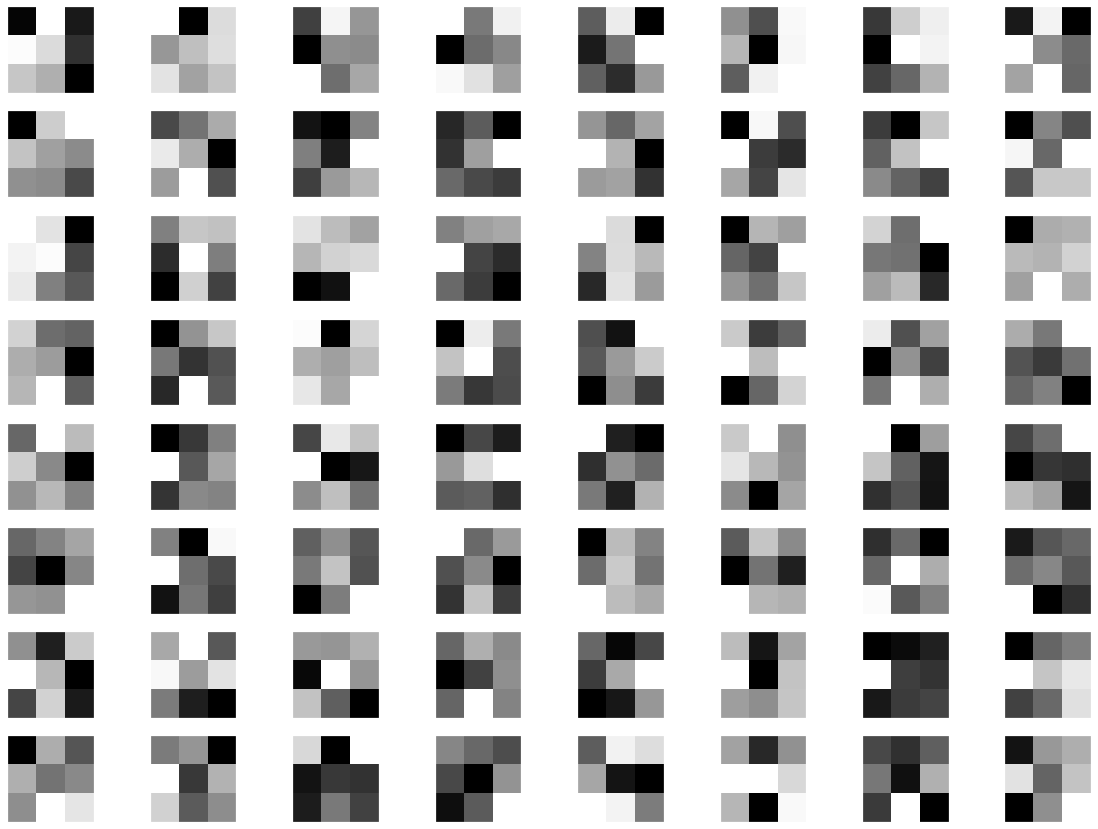

layer : Conv10 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


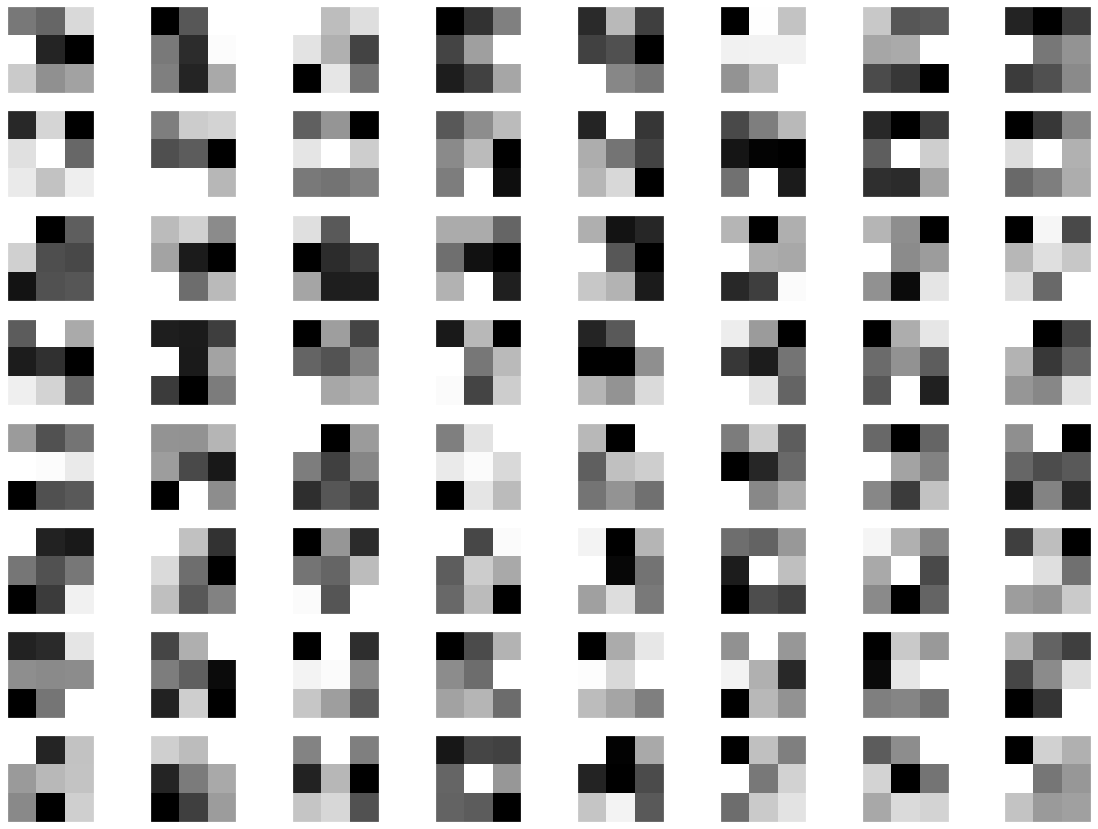

layer : Conv11 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


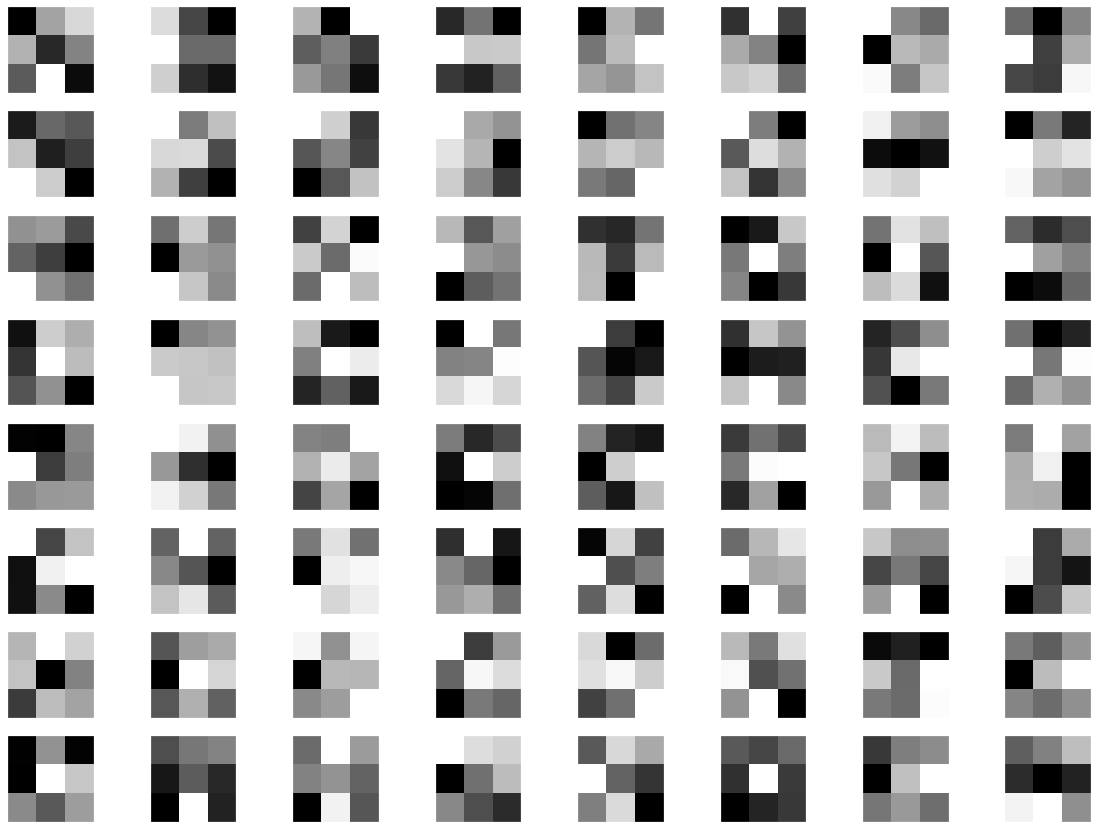

layer : Bnorm8 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


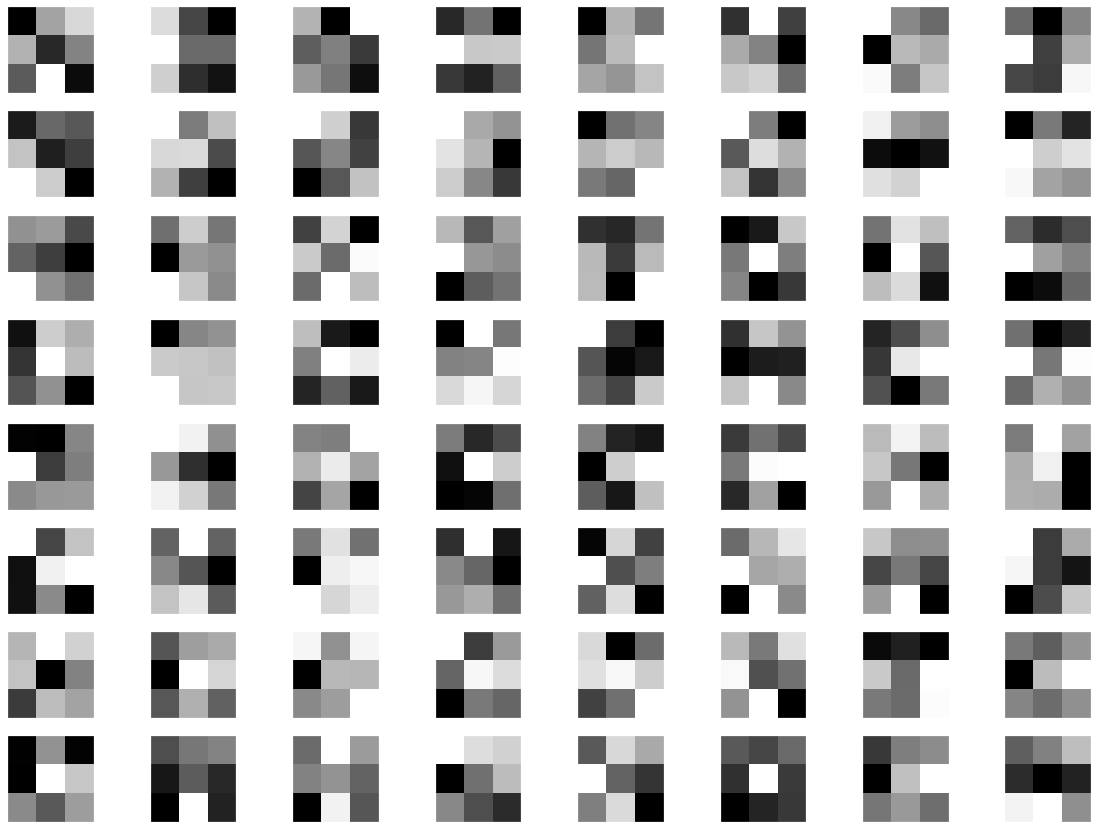

layer : leaky_re_lu_27 , feature map shape : (1, 3, 3, 512)
nrow : 64 , ncol : 8


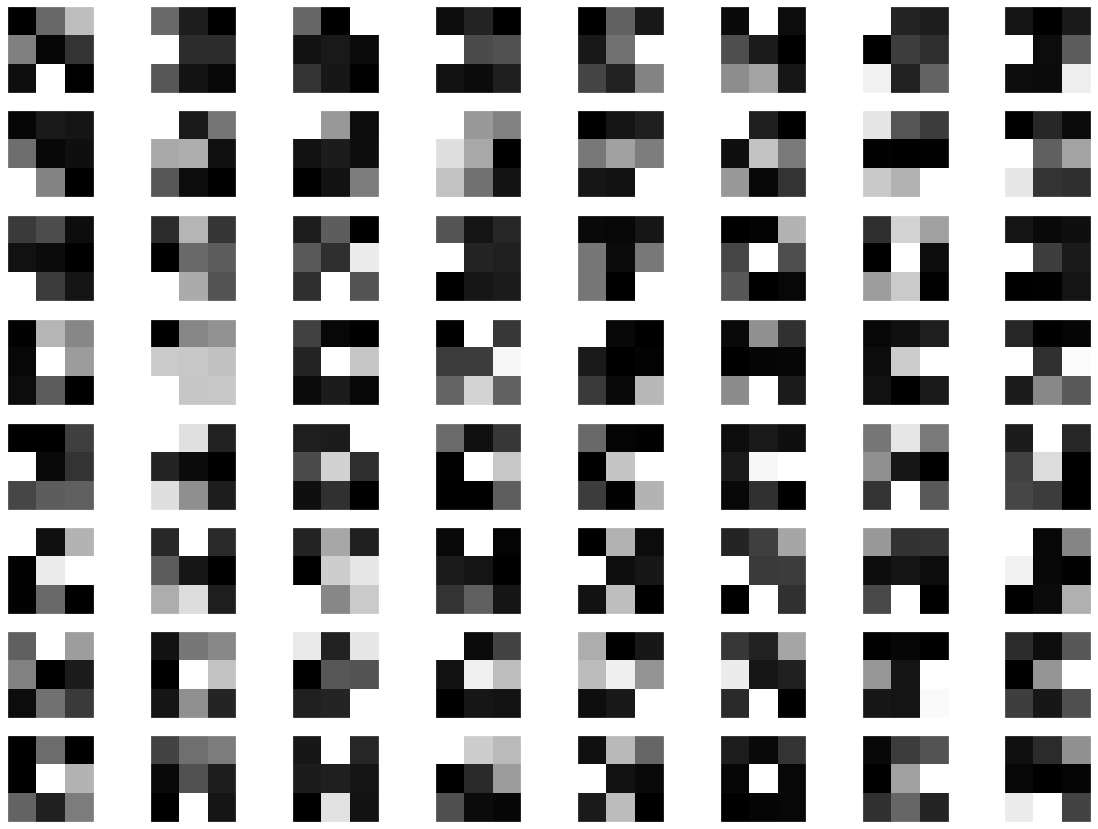

layer : Conv12 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


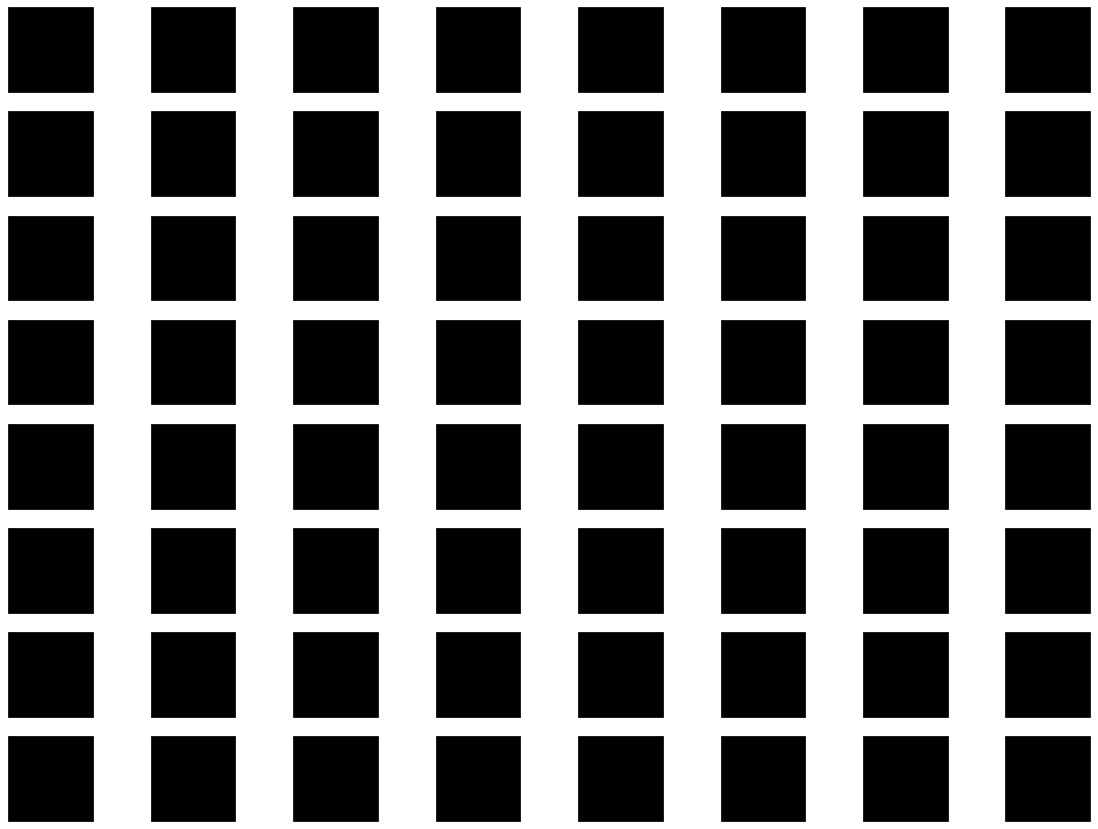

layer : Bnorm9 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


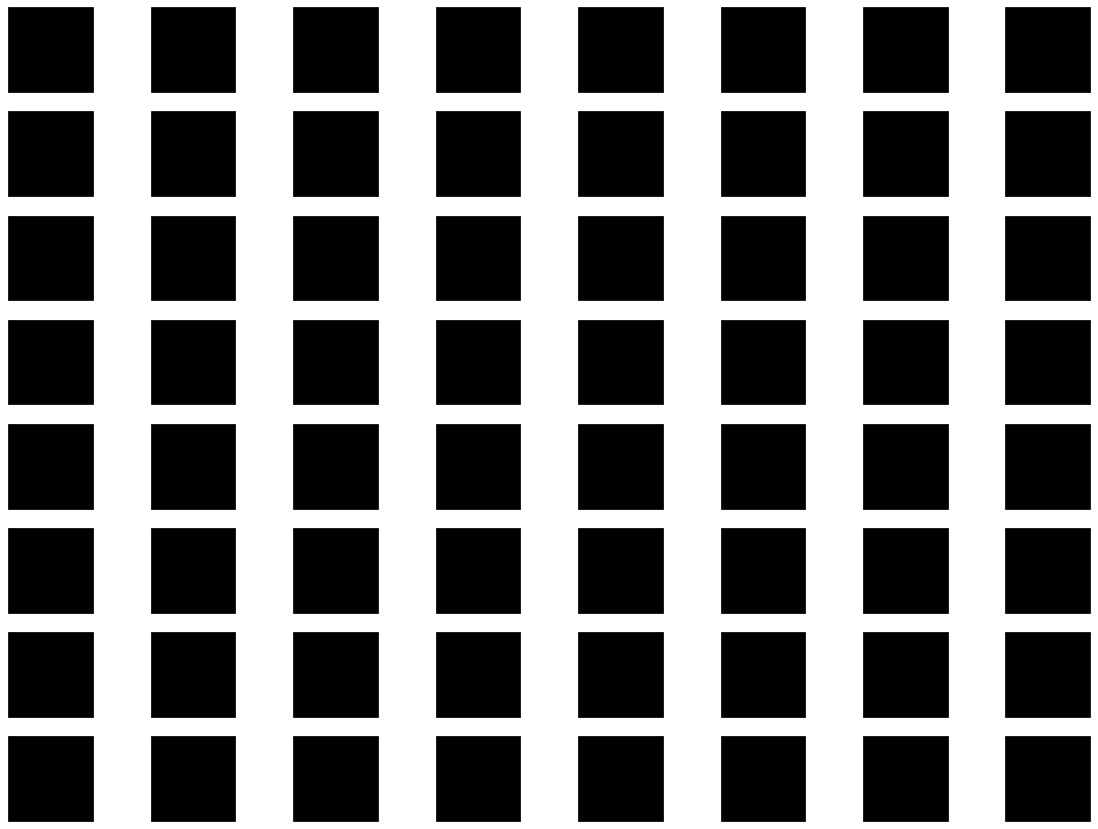

layer : leaky_re_lu_28 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


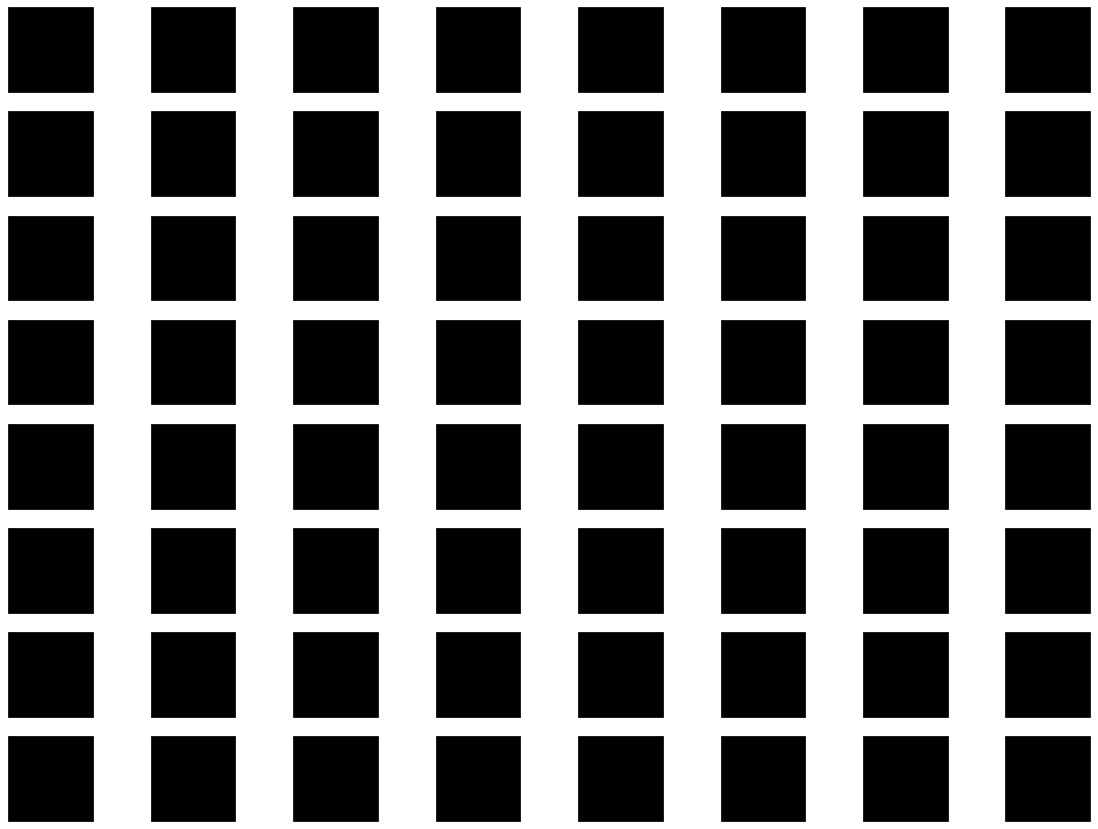

layer : Conv13 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


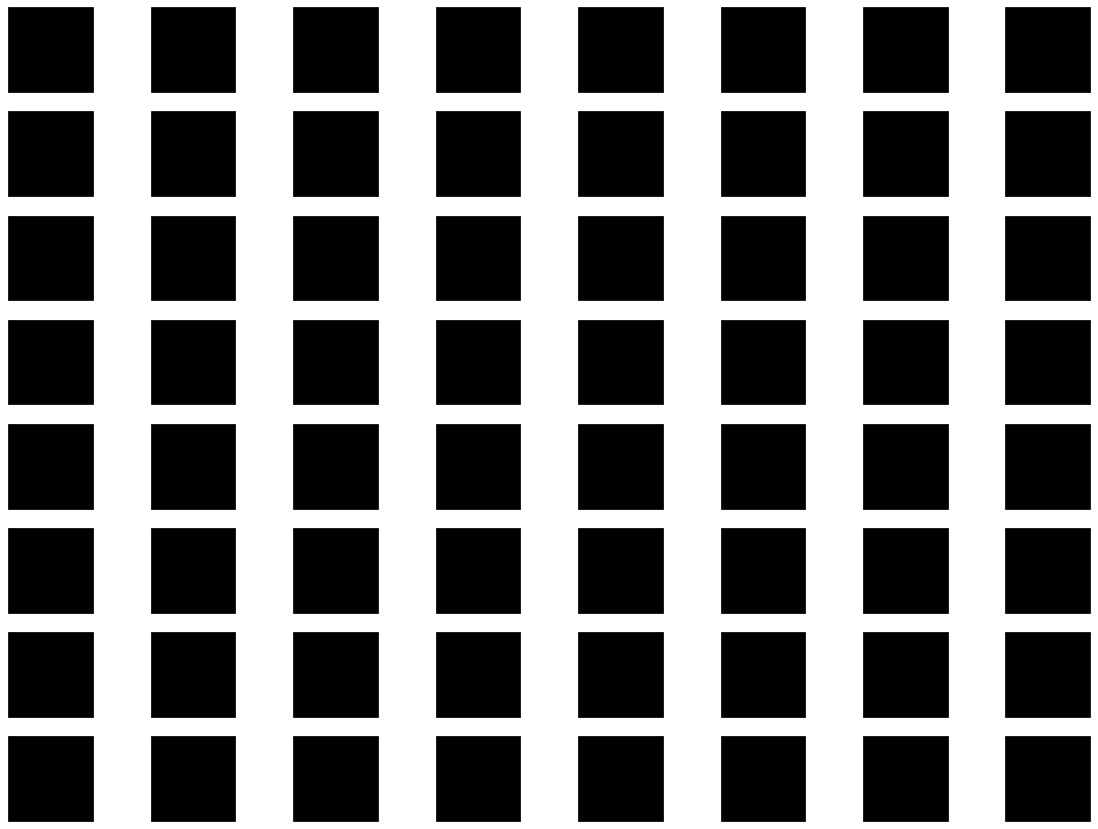

layer : Bnorm10 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


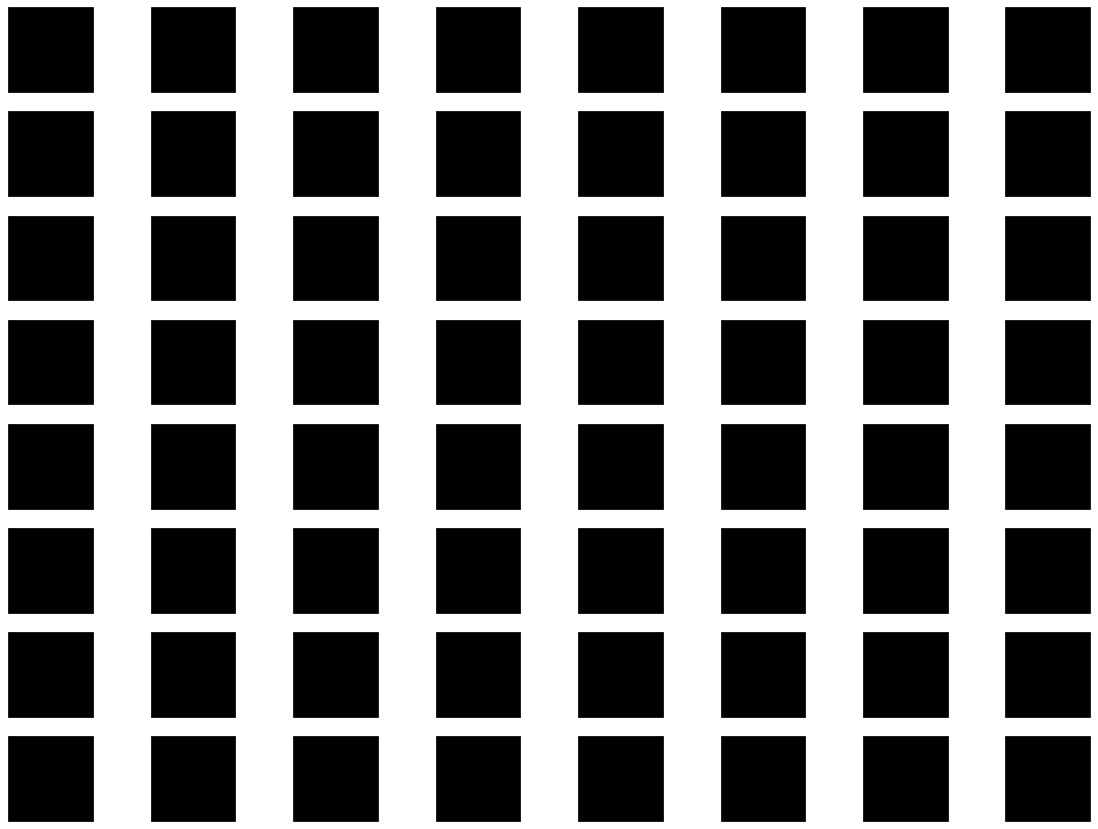

layer : Conv14 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


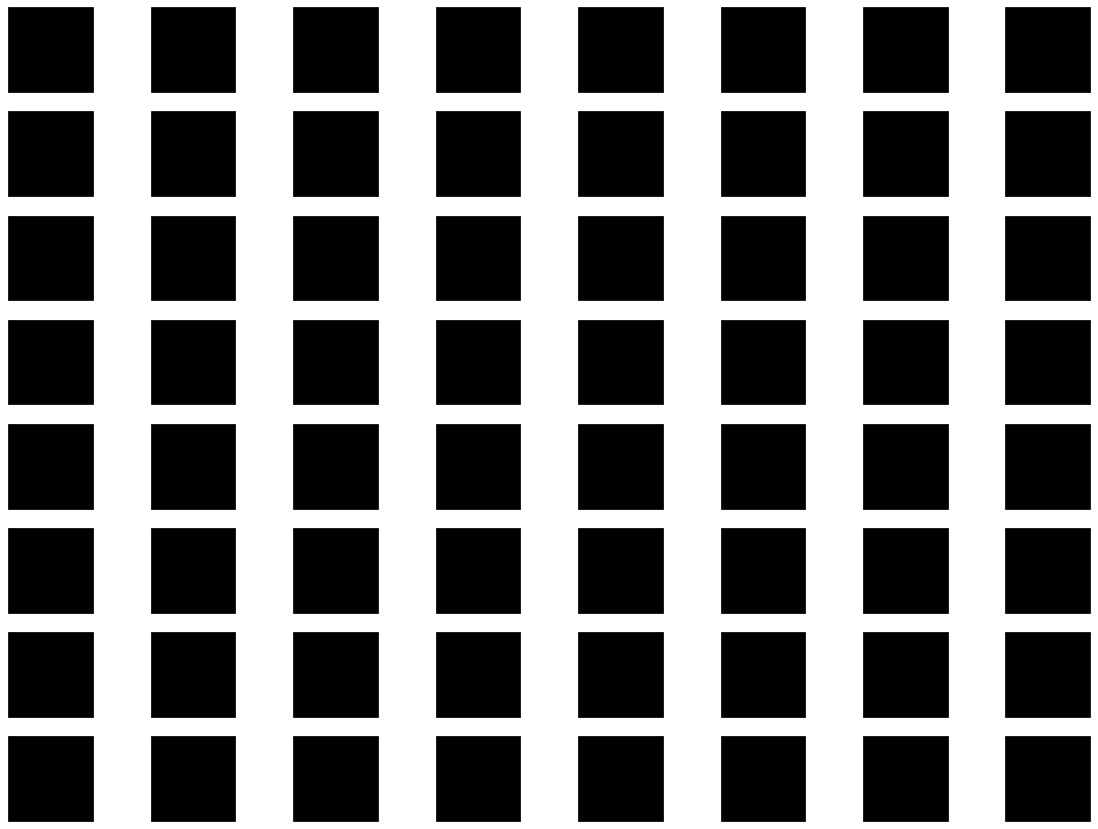

layer : Conv15 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


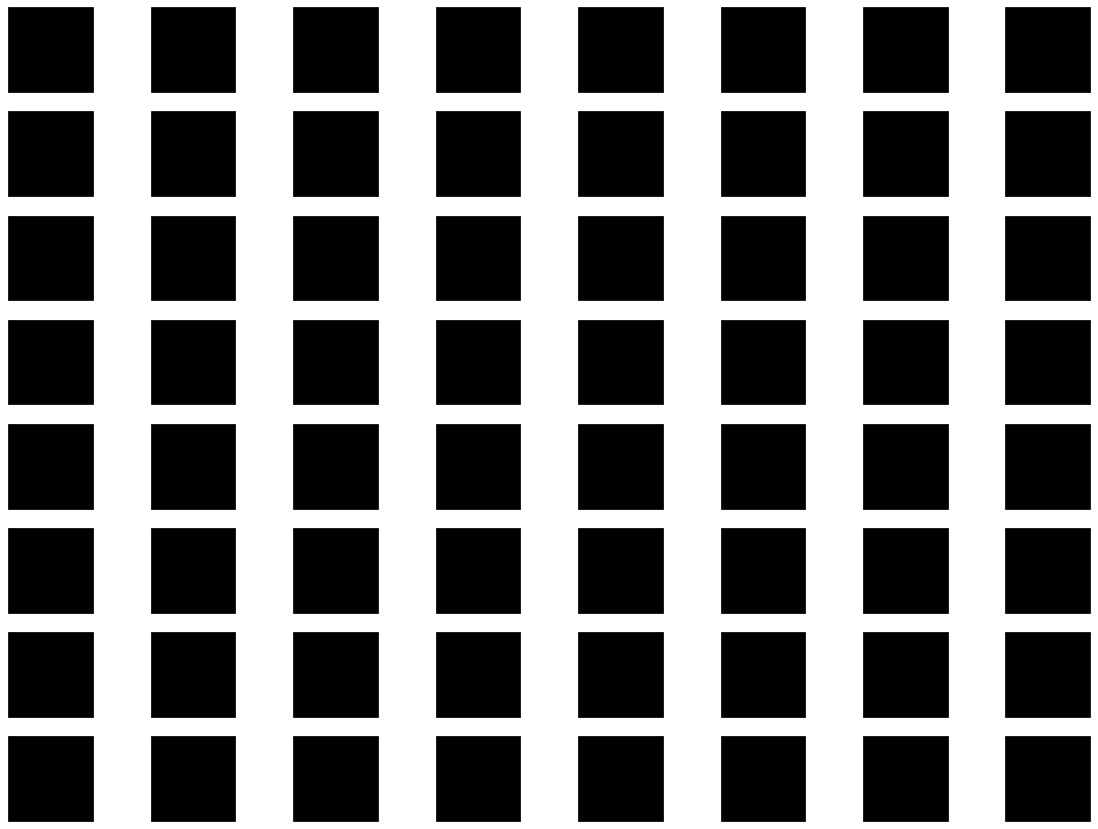

layer : Bnorm11 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


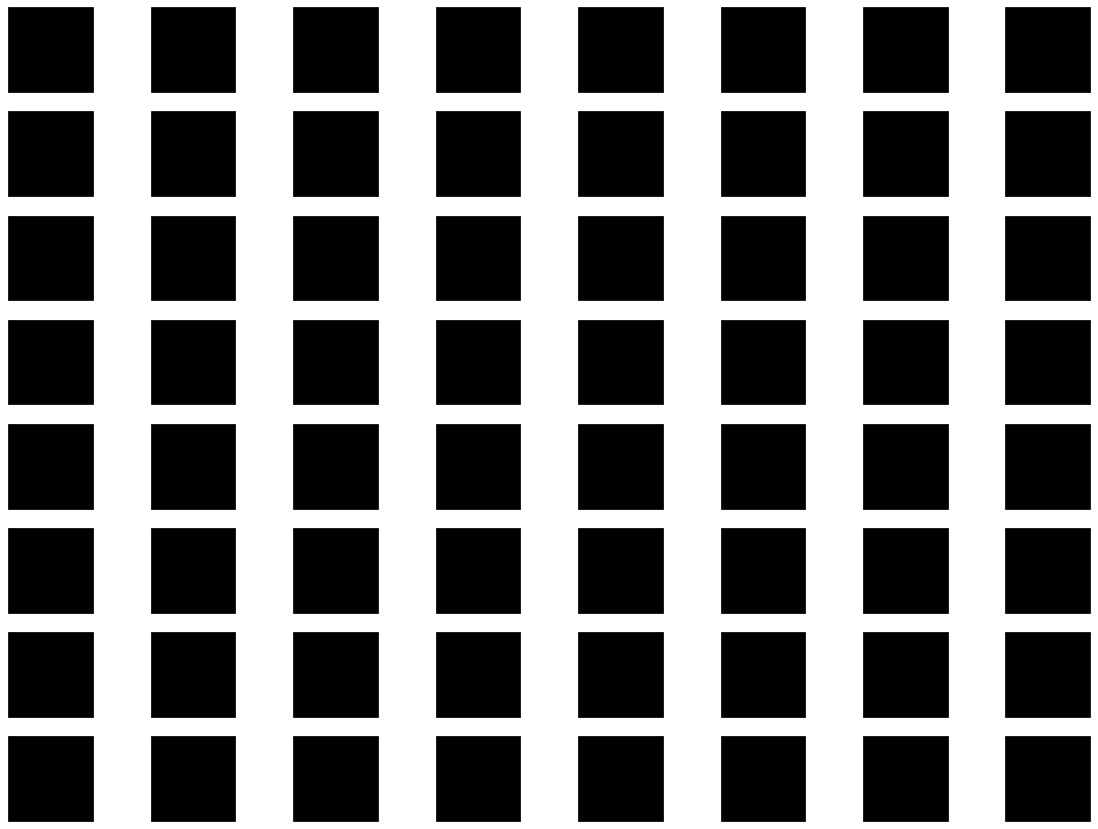

layer : leaky_re_lu_29 , feature map shape : (1, 1, 1, 1024)
nrow : 128 , ncol : 8


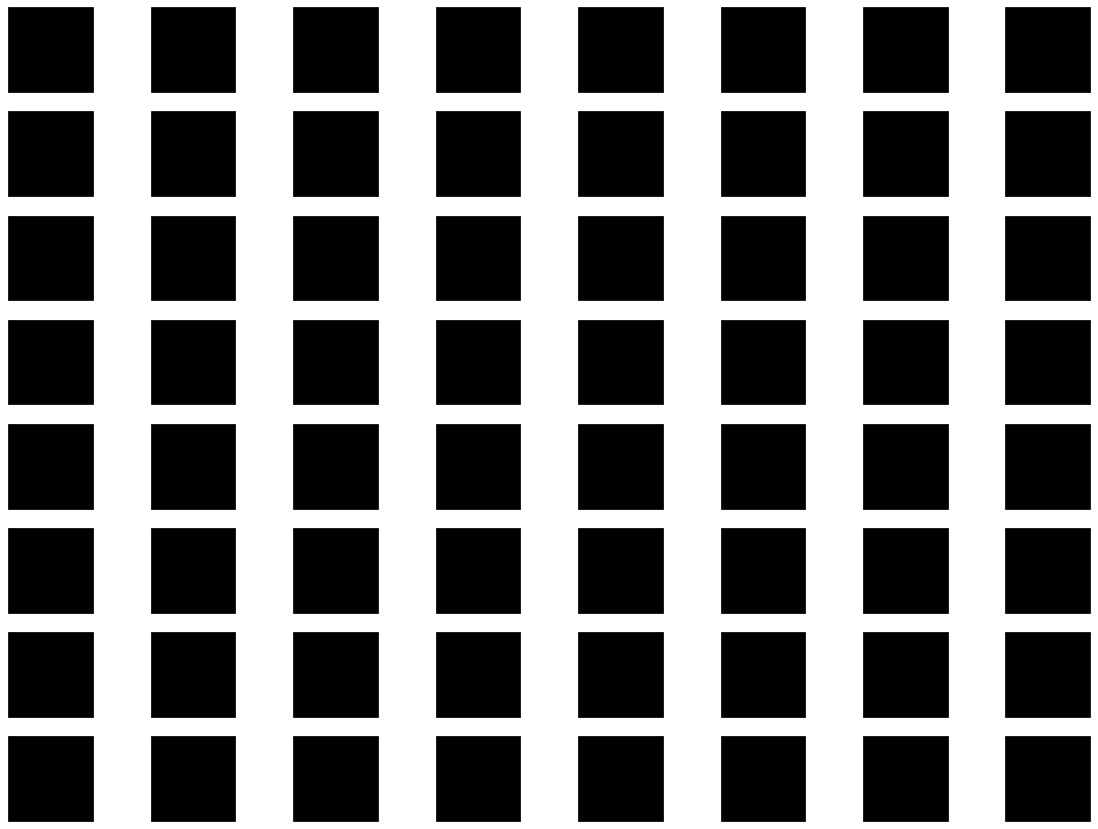

layer : Conv16 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


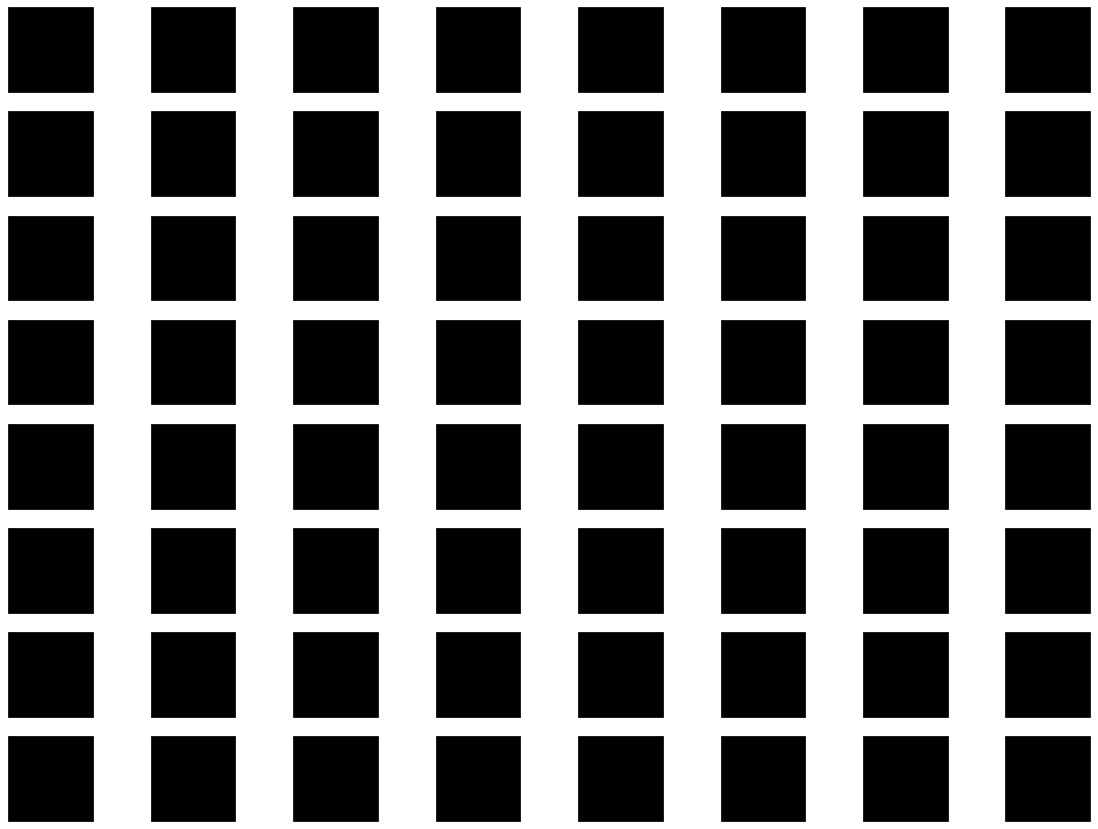

layer : Bnorm12 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


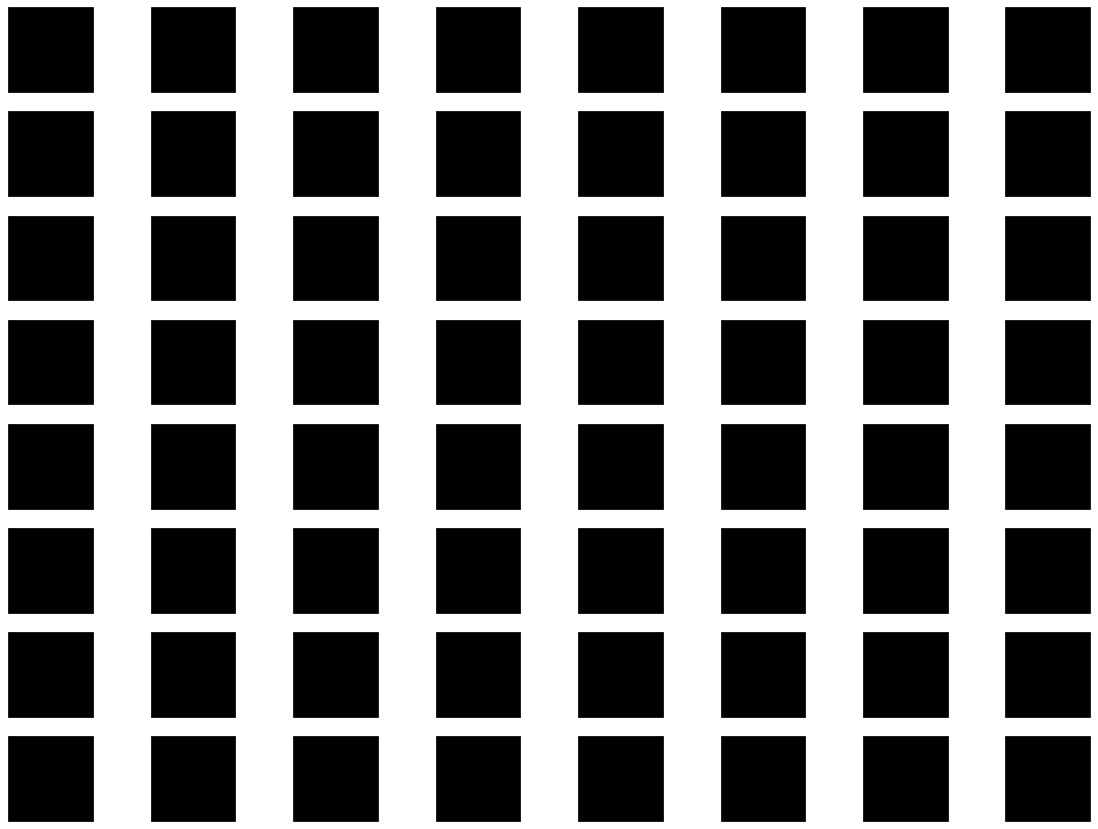

layer : leaky_re_lu_30 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


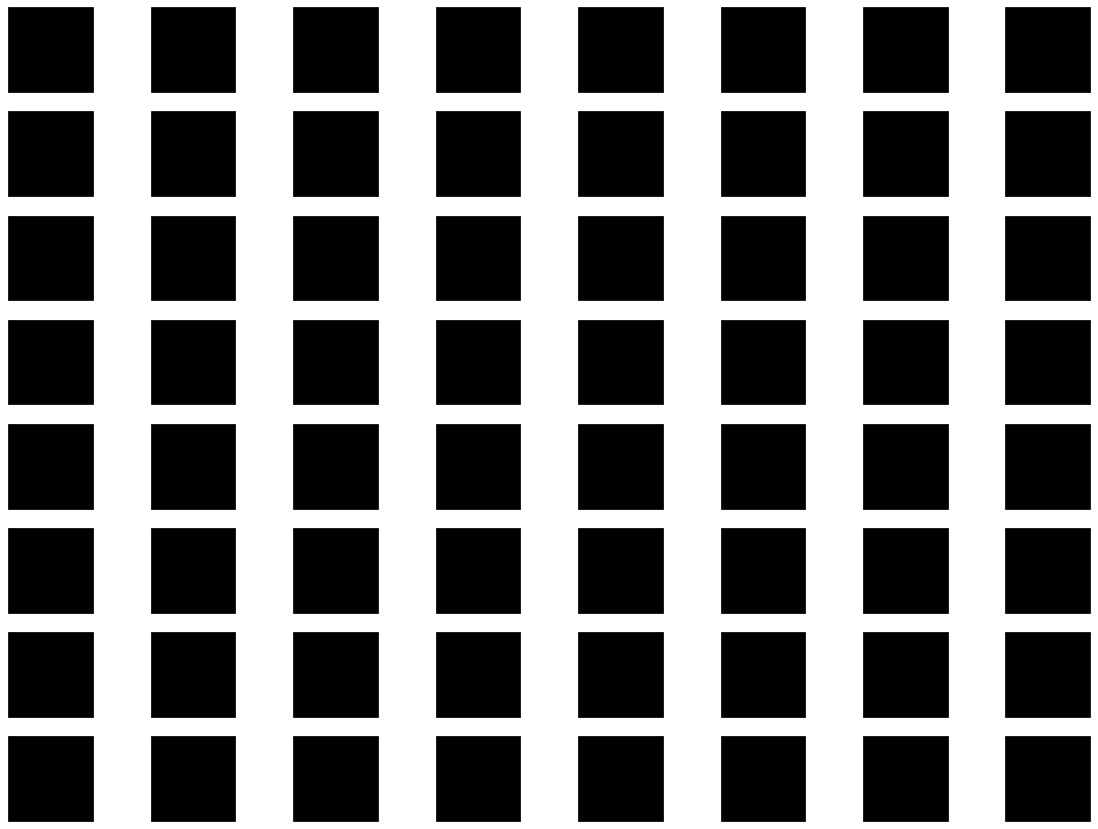

layer : Conv17 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


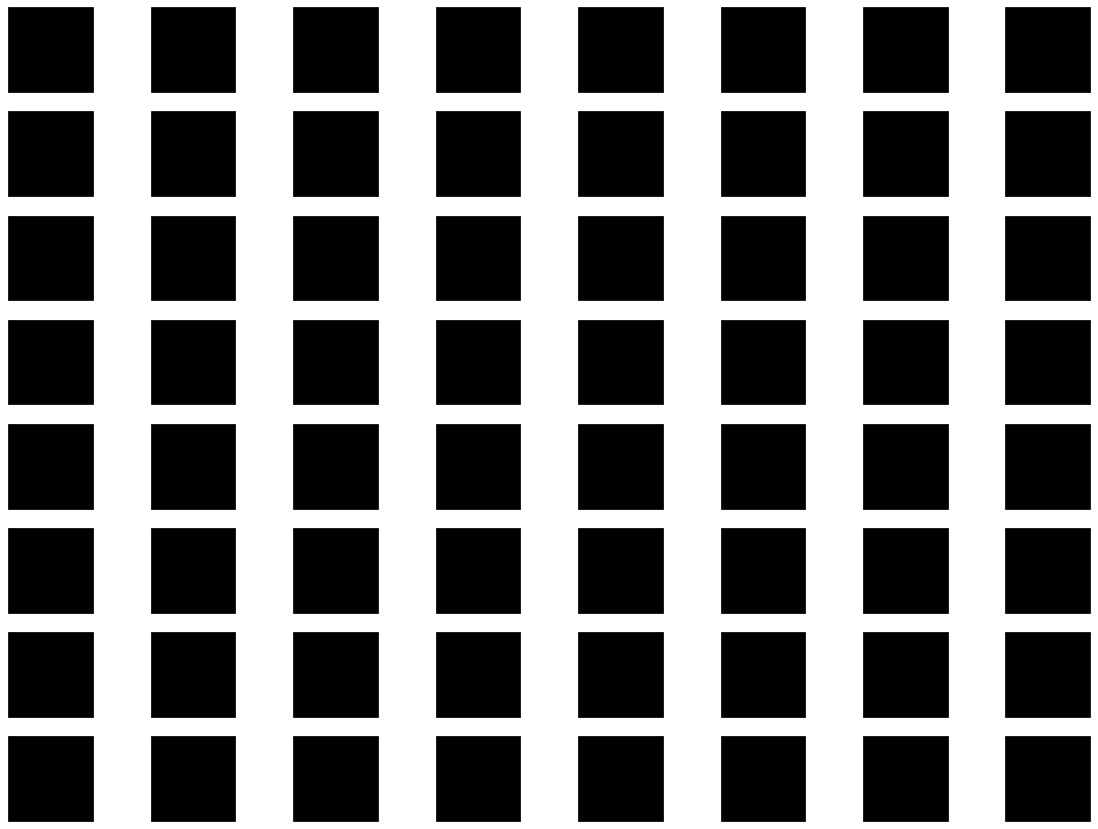

layer : Bnorm13 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


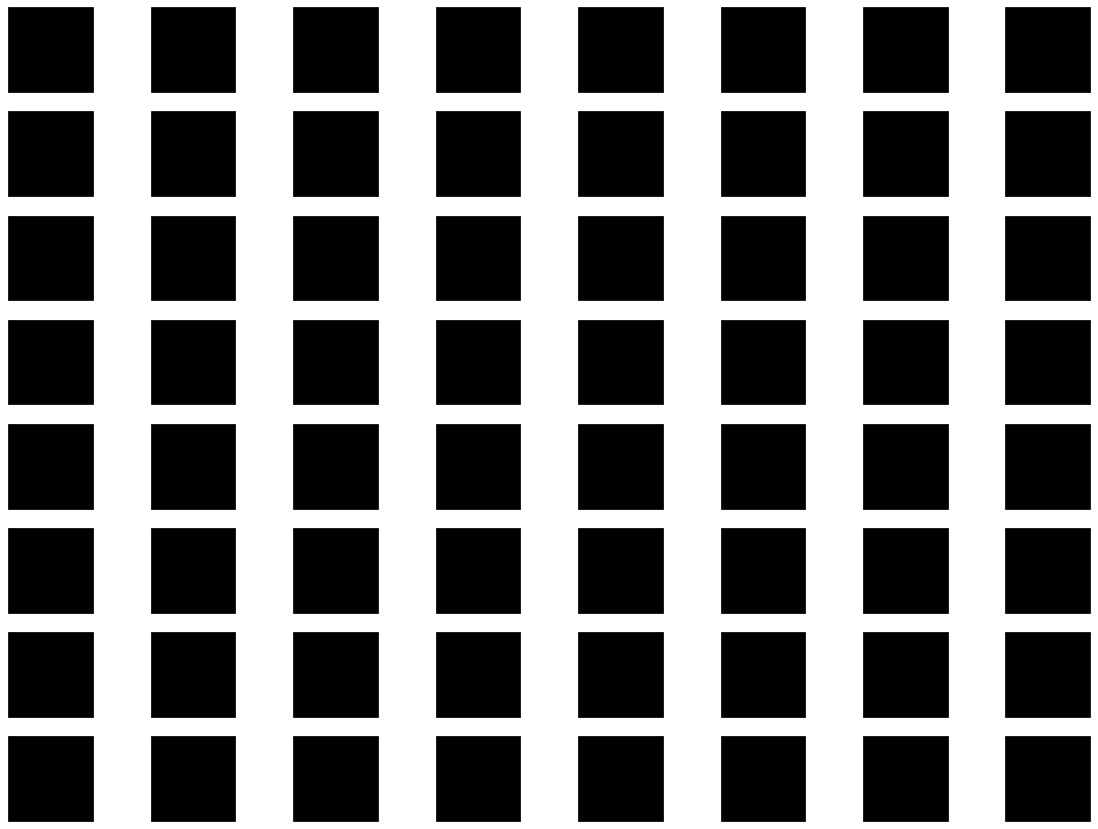

layer : leaky_re_lu_31 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


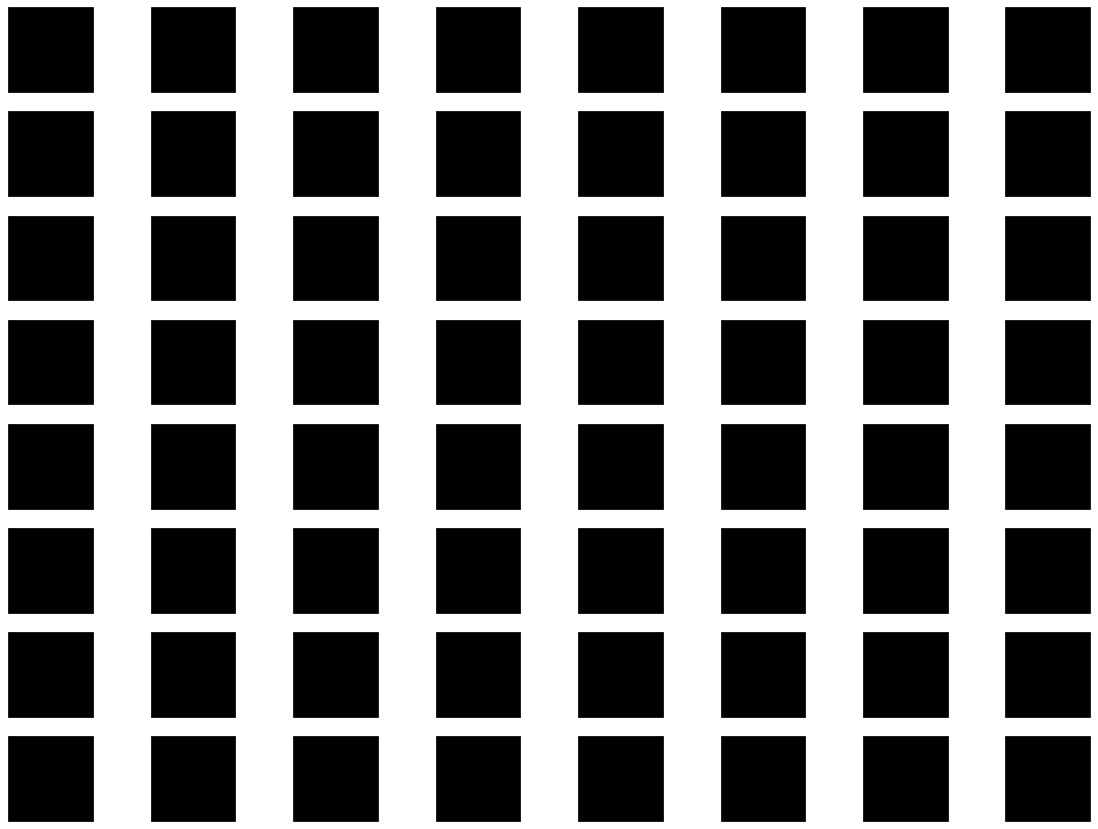

layer : AvgPool1 , feature map shape : (1, 1, 1, 128)
nrow : 16 , ncol : 8


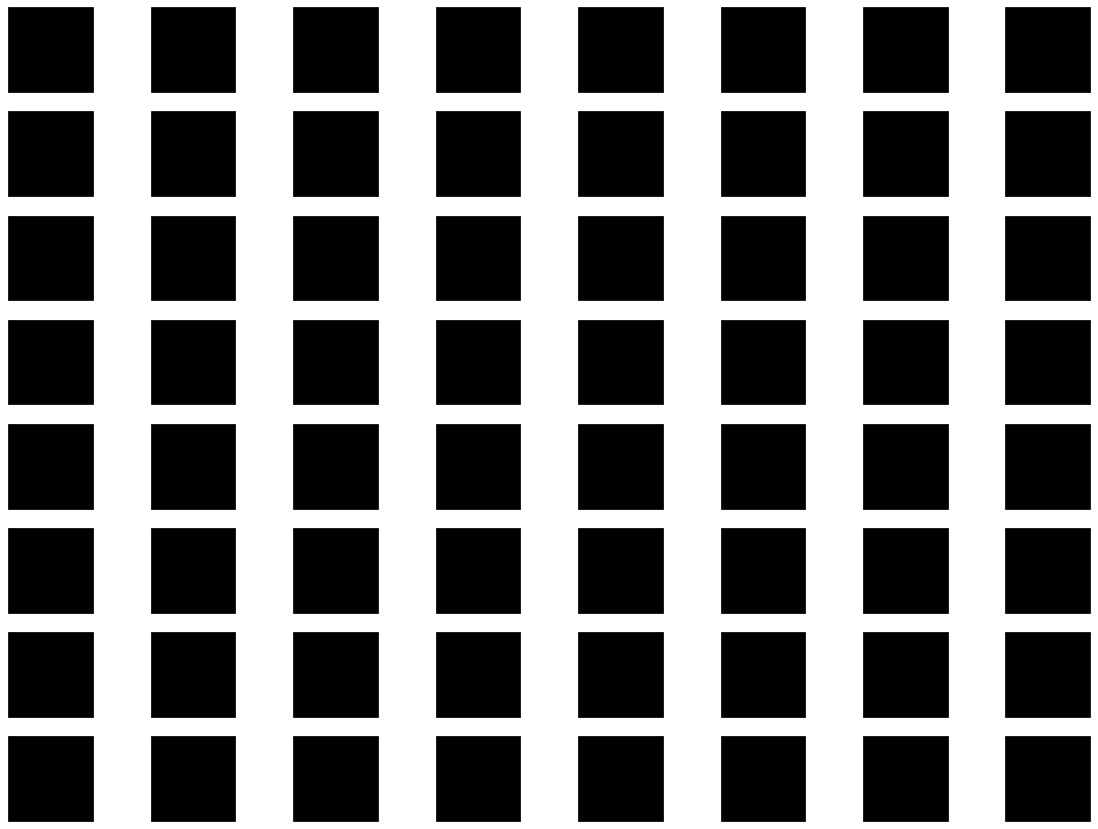

In [ ]:
#for Question 6
for n_layer in range(1,42):
  model_layer = Model(inputs=model.inputs, outputs=model.layers[n_layer].output)
  feature_maps = model_layer.predict(trainX[336].reshape(1,32,32,1))
  print('layer : {} , feature map shape : {}'.format(model.layers[n_layer].name,feature_maps.shape))

  n_row = int(feature_maps.shape[-1]/8)
  n_col = 8
  print('nrow : {} , ncol : {}'.format(n_row,n_col))
  plt.figure(figsize=(20,15))
  ix = 1
  for _ in range(8):
	  for _ in range(n_col):
		  # specify subplot and turn of axis
		  ax = plt.subplot(8, n_col, ix)
		  ax.set_xticks([])
		  ax.set_yticks([])
		  # plot filter channel in grayscale
		  plt.imshow(feature_maps[0, :, :, ix-1] , cmap='gray')
		  ix += 1
  # show the figure
  plt.show()

layer : iConv1_5 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


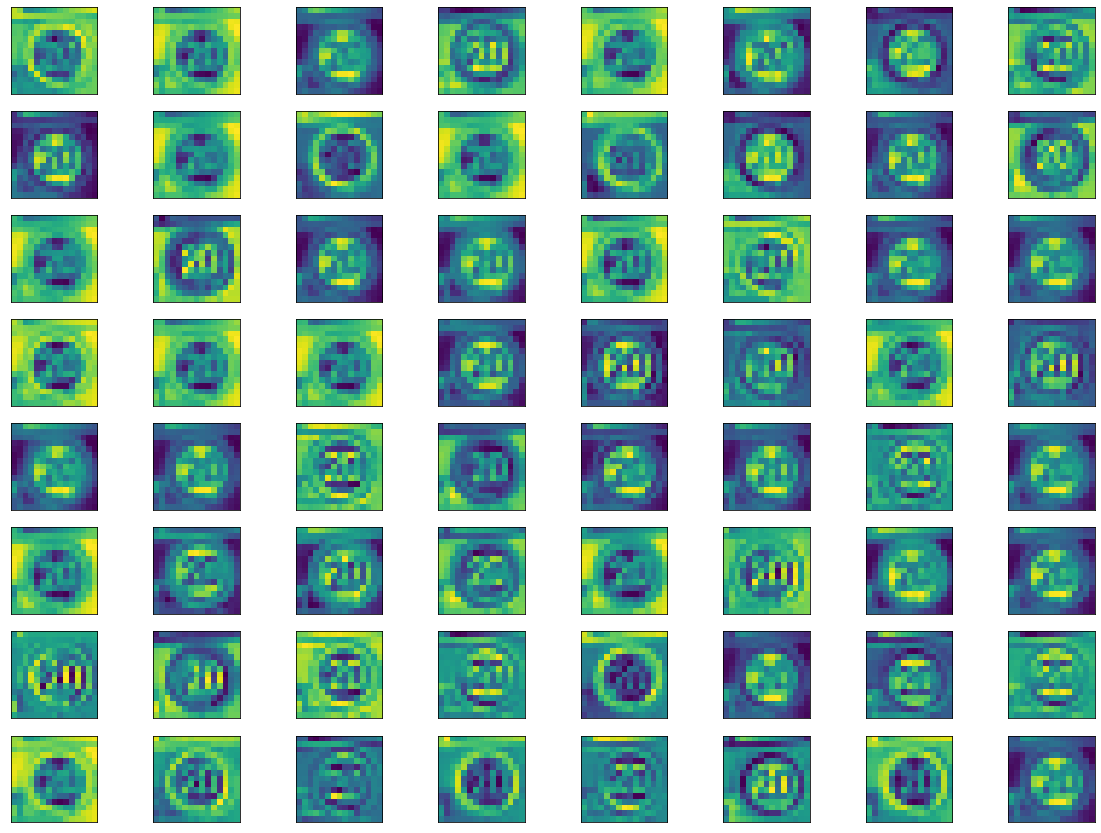

layer : iBnorm1 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


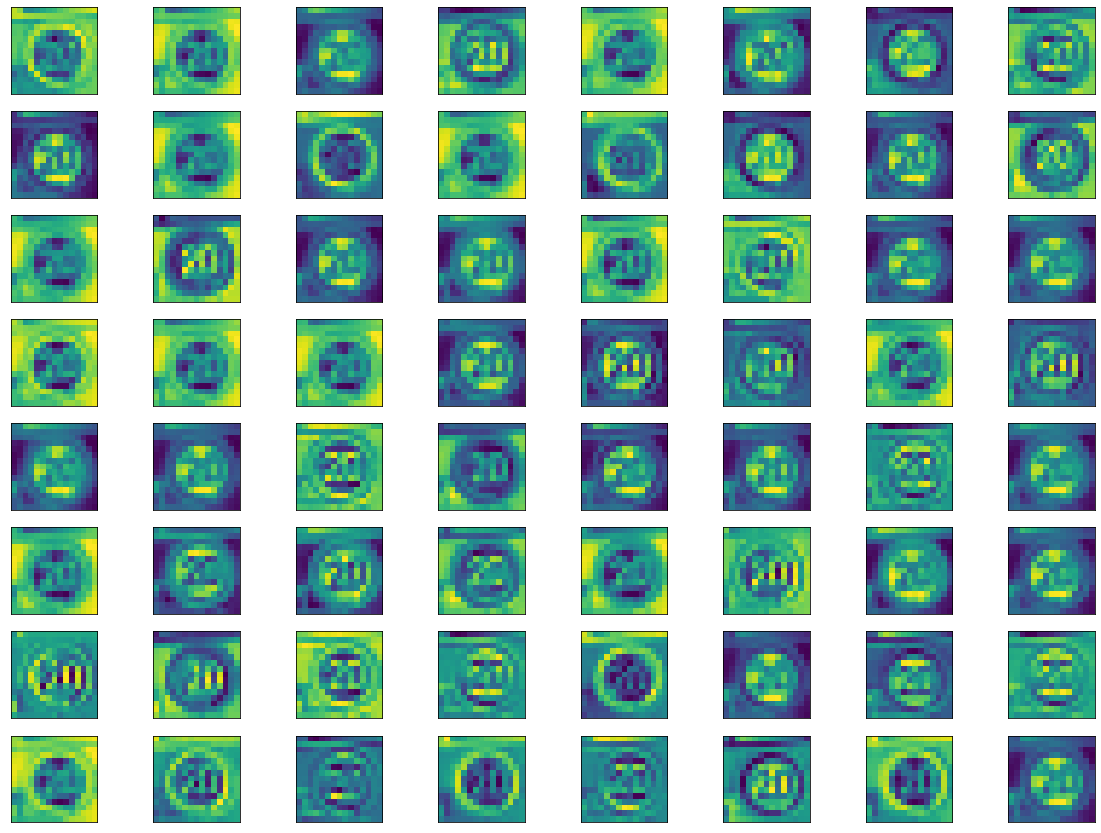

layer : leaky_re_lu_40 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


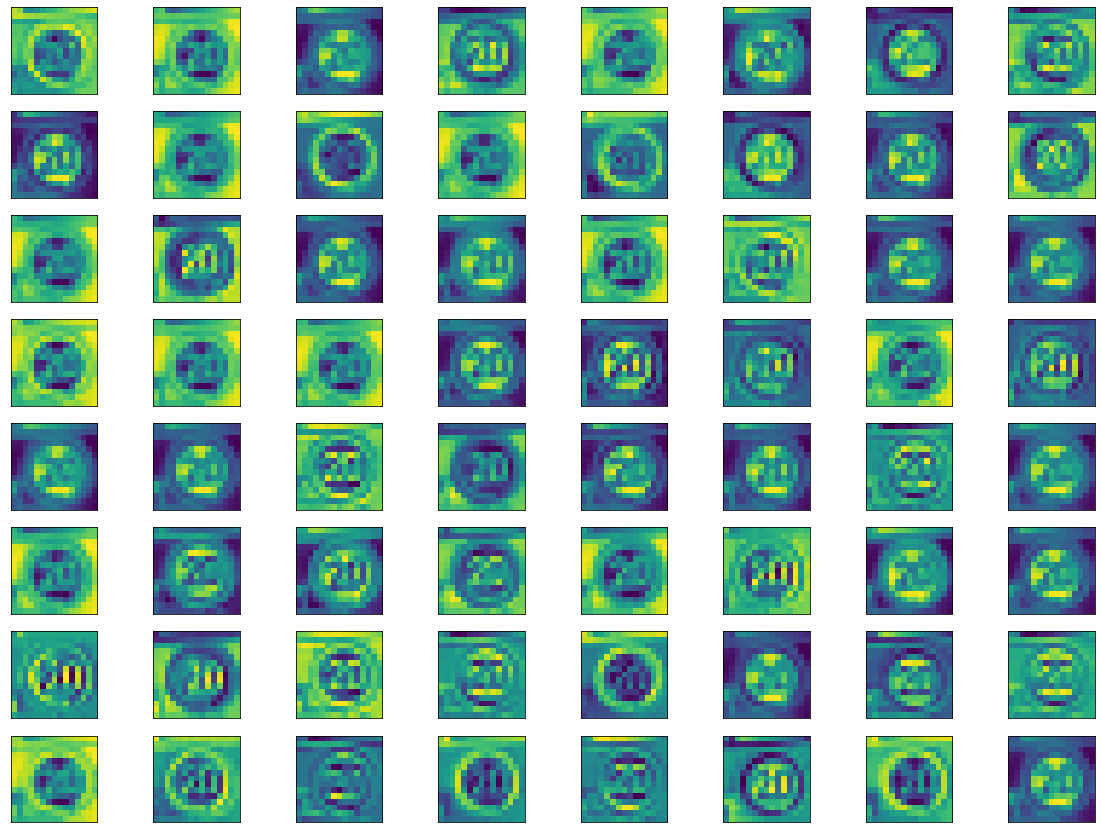

layer : Conv1_5 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


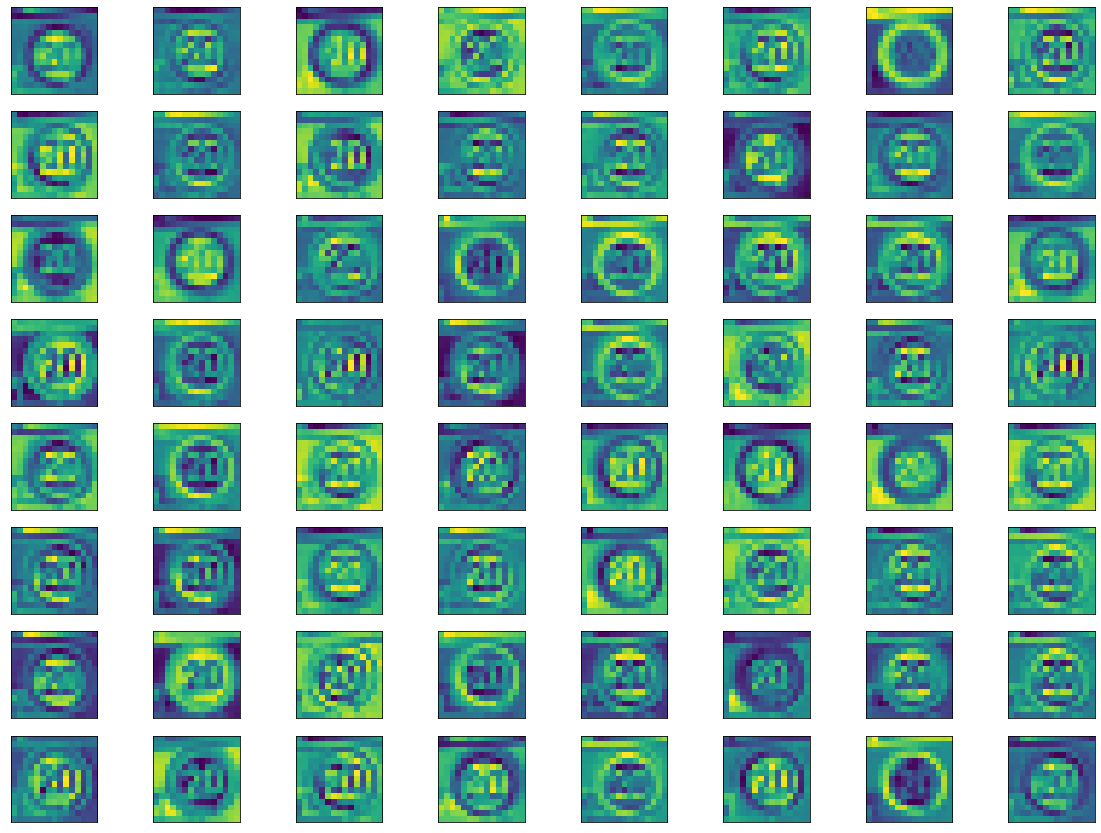

layer : Conv2_5 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


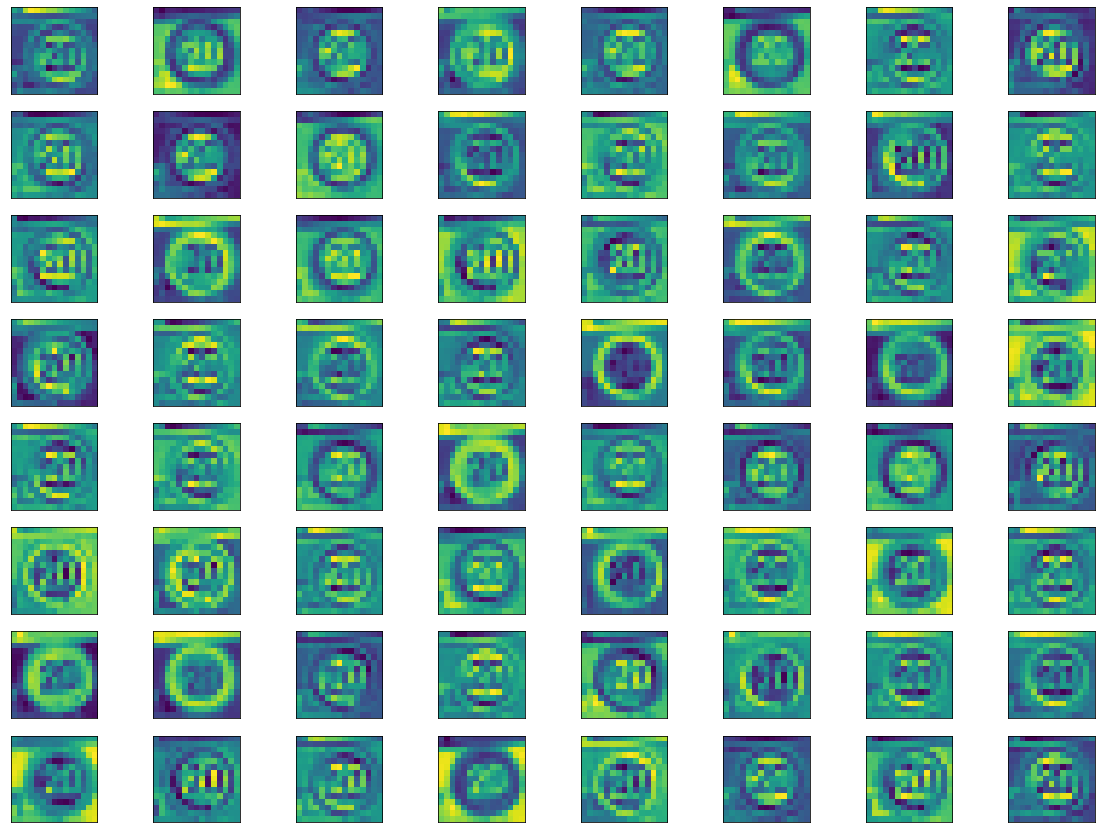

layer : Bnorm2 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


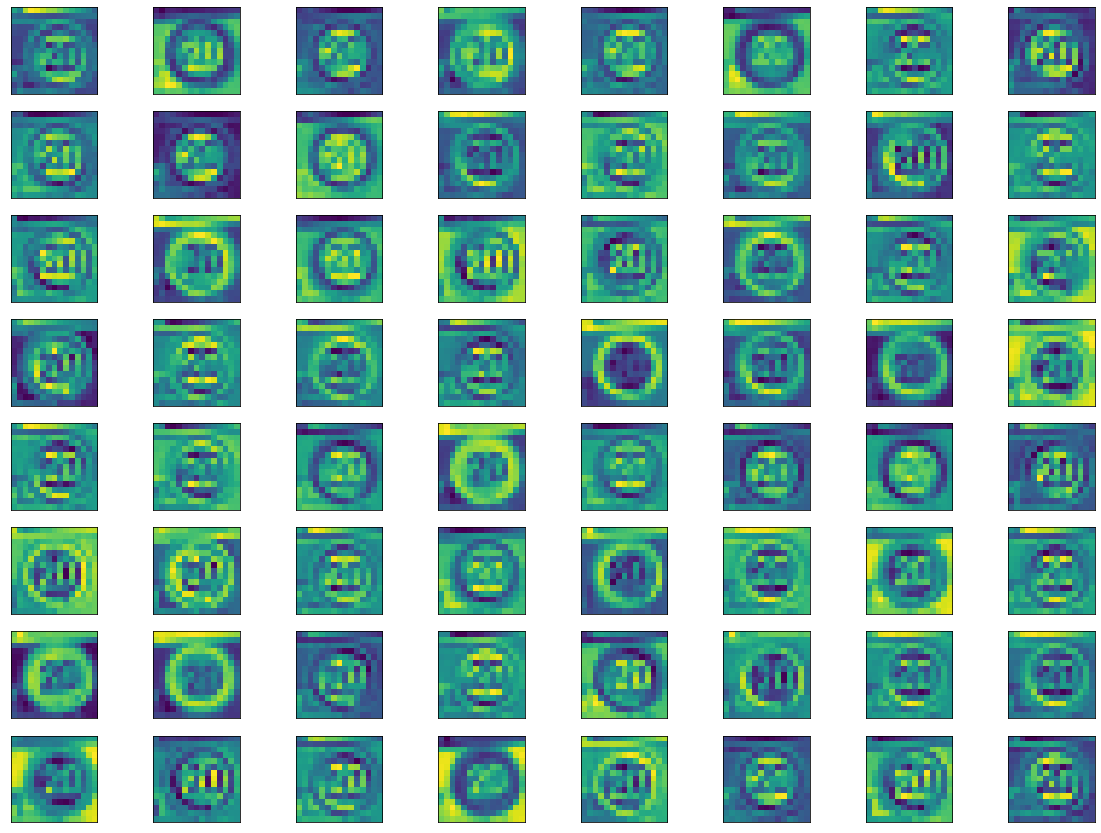

layer : leaky_re_lu_41 , feature map shape : (1, 15, 15, 64)
nrow : 8 , ncol : 8


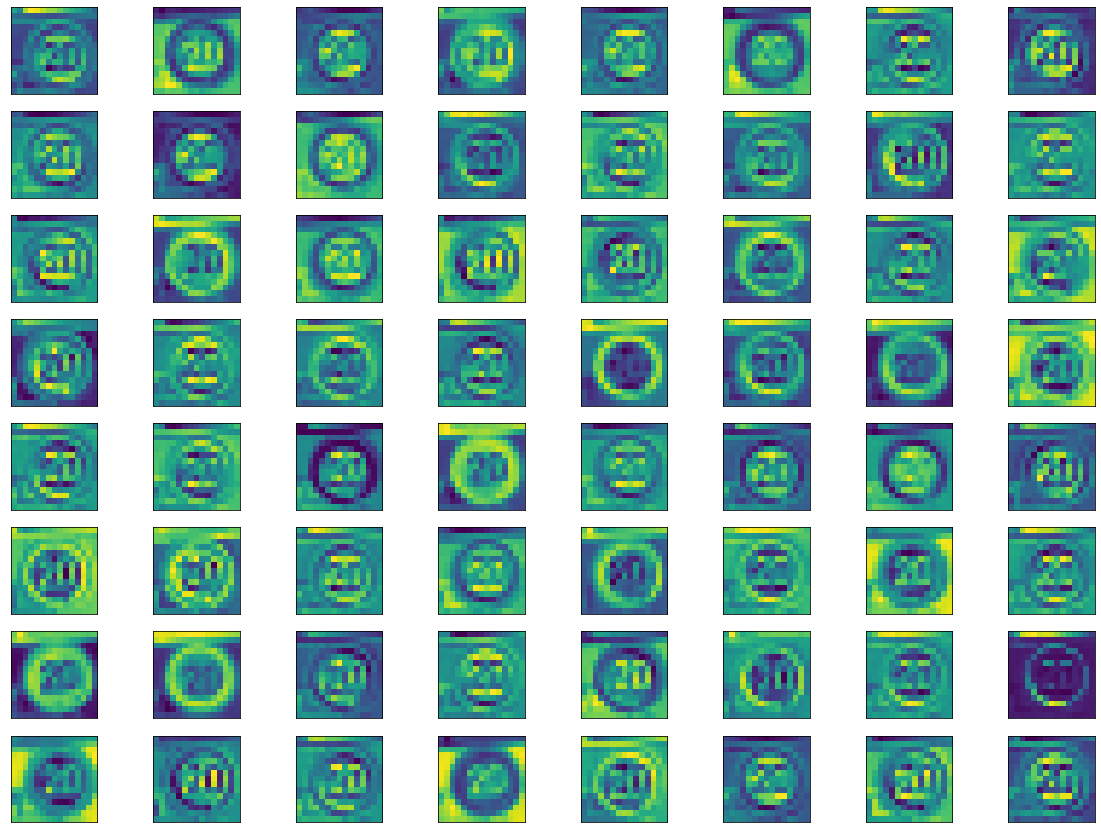

layer : aConv1_5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


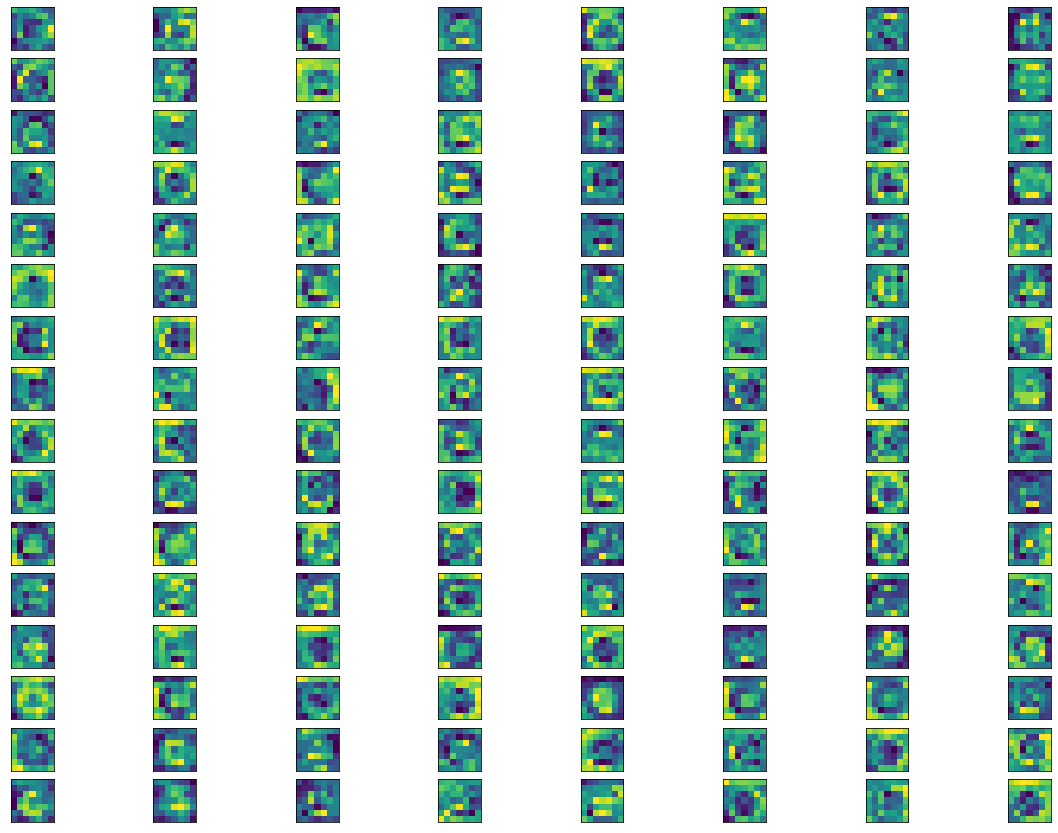

layer : aBnorm1 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


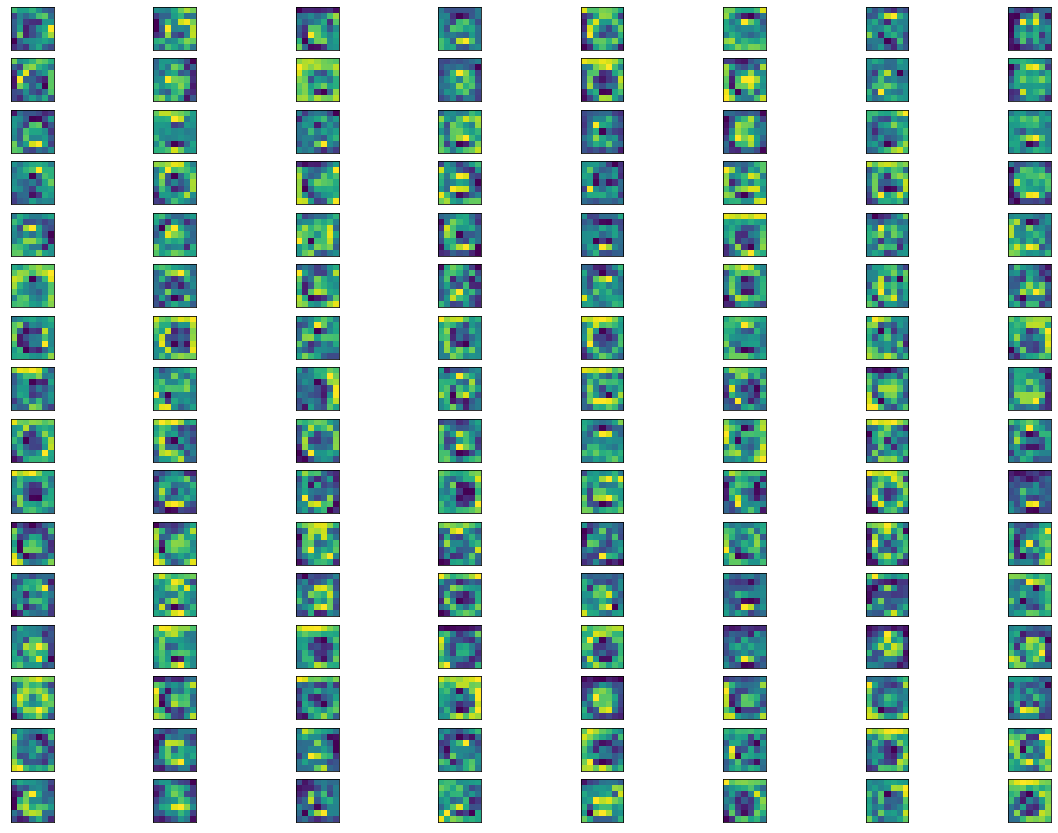

layer : leaky_re_lu_42 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


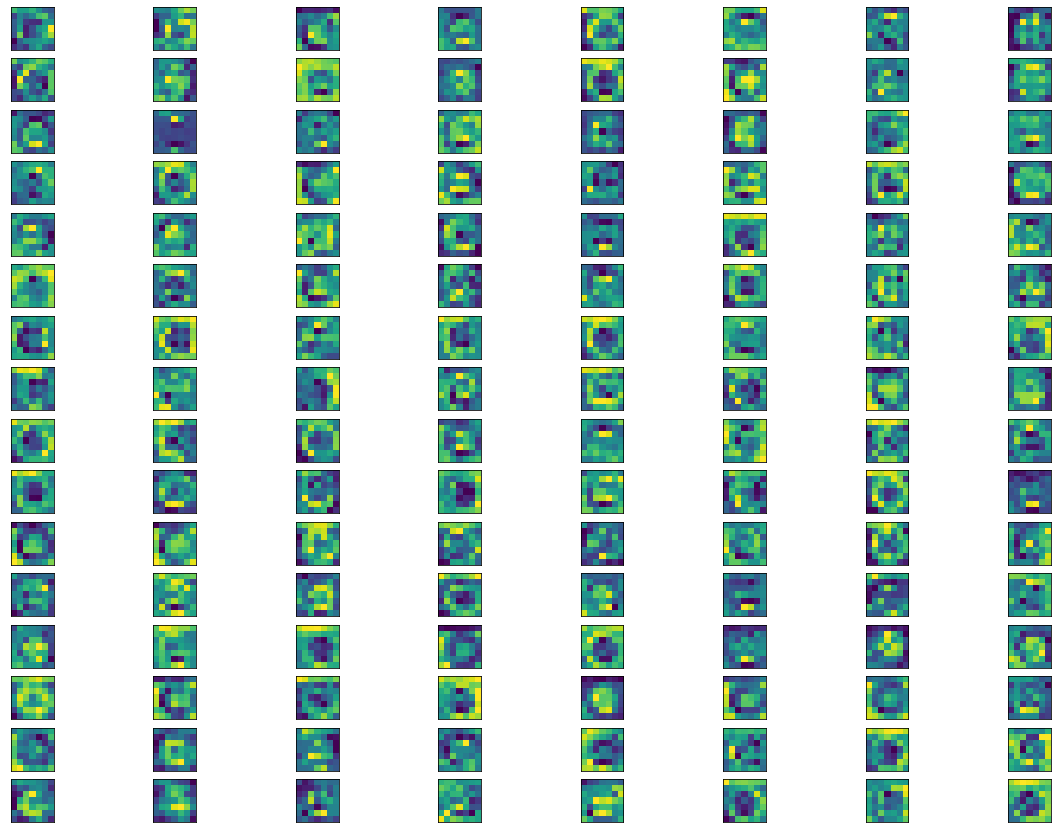

layer : aConv2_5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


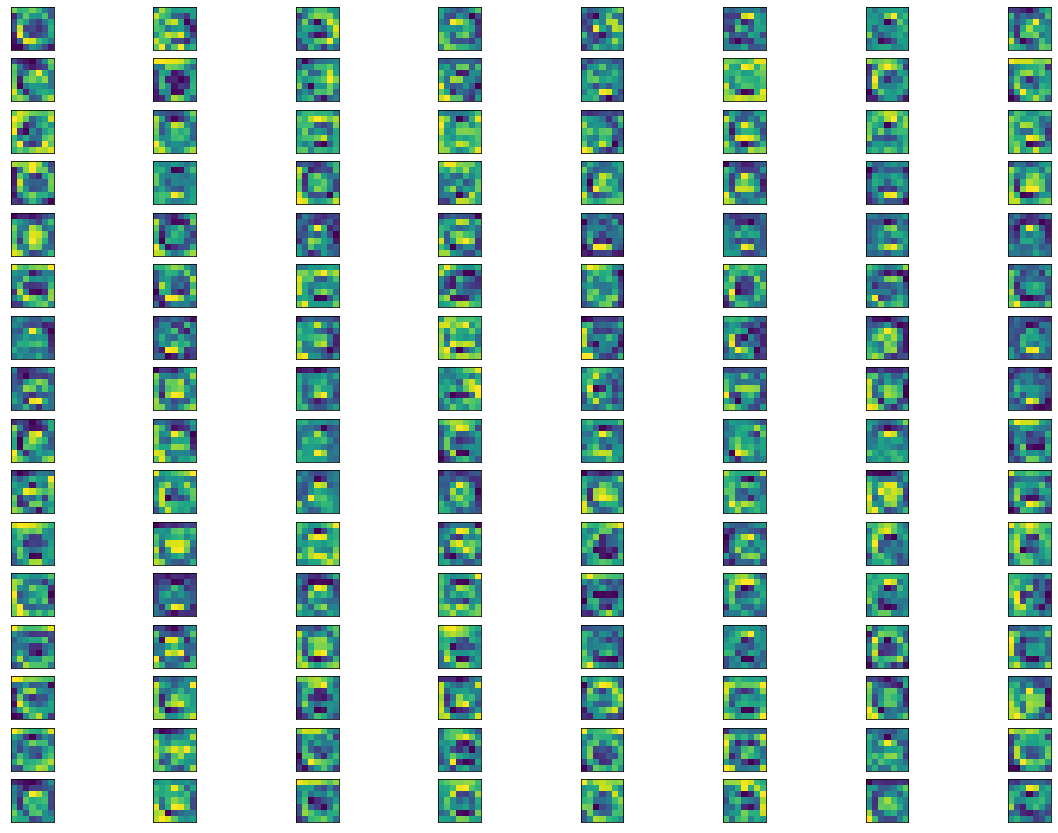

layer : aBnorm2 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


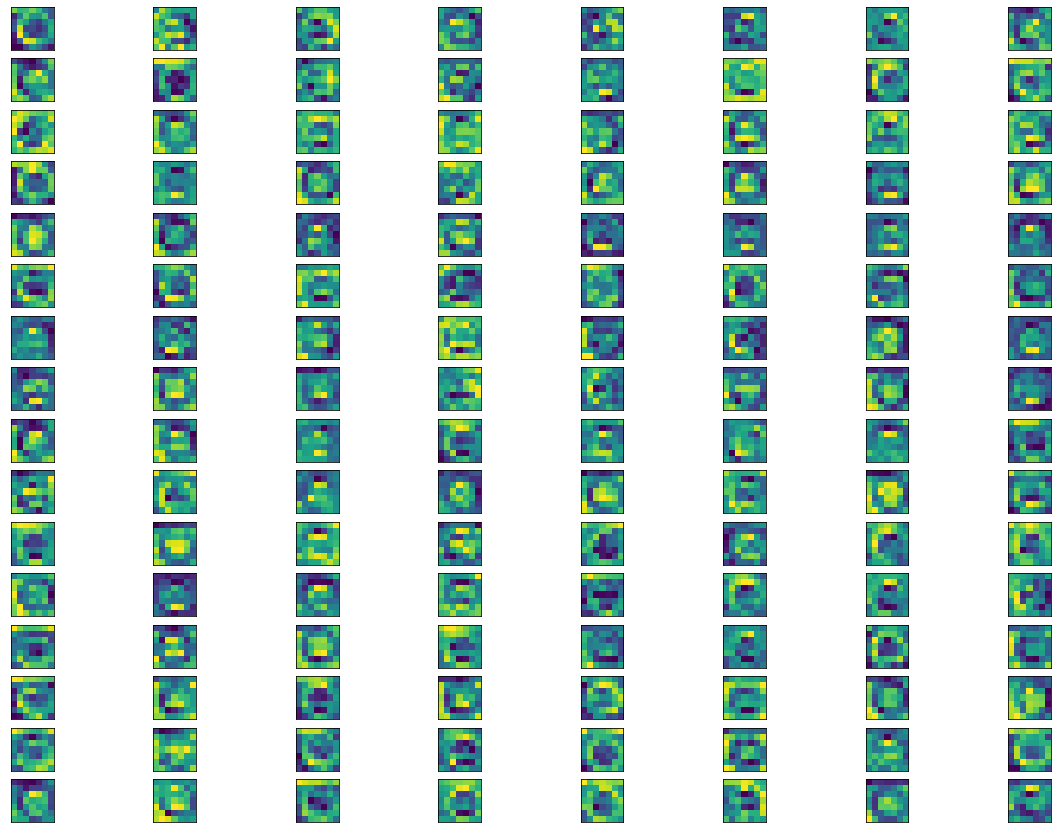

layer : cConv1_5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


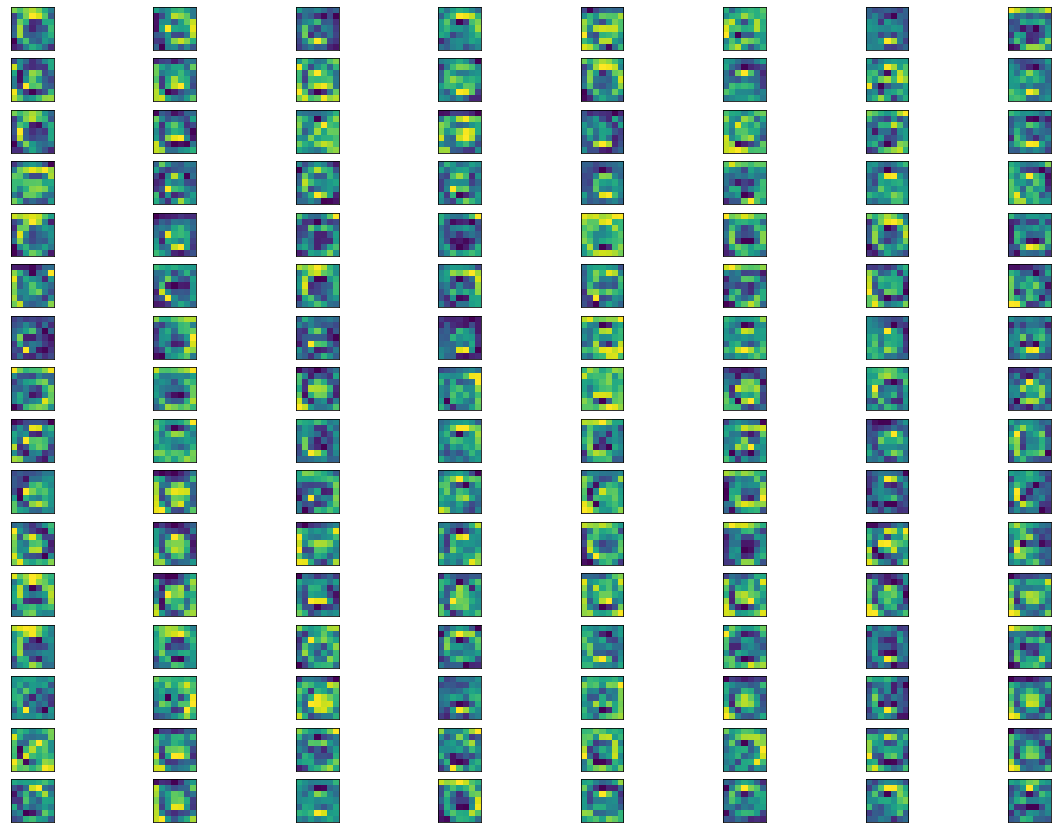

layer : cConv2_5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


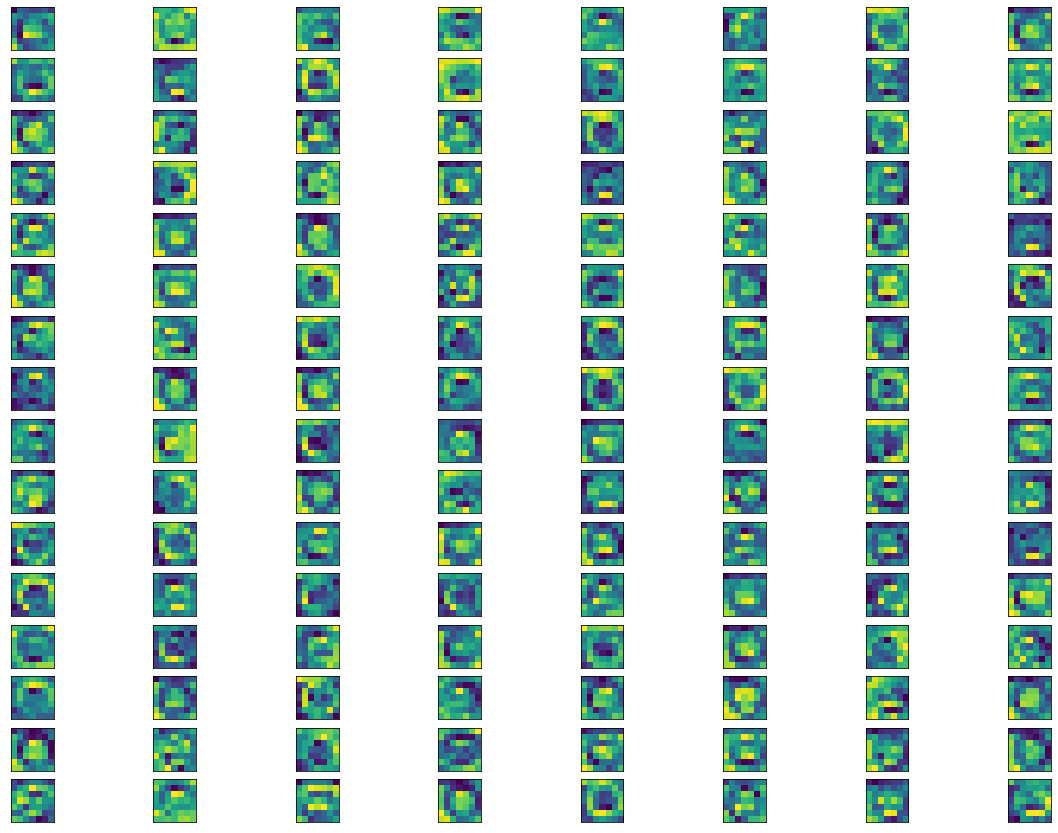

In [ ]:
#for Question 6
for n_layer in range(1,15):
  model_layer = Model(inputs=model.inputs, outputs=model.layers[n_layer].output)
  feature_maps = model_layer.predict(trainX[1].reshape(1,32,32,3))
  print('layer : {} , feature map shape : {}'.format(model.layers[n_layer].name,feature_maps.shape))

  n_row = int(feature_maps.shape[-1]/8)
  n_col = 8
  print('nrow : {} , ncol : {}'.format(n_row,n_col))
  plt.figure(figsize=(20,15))
  ix = 1
  for _ in range(n_row):
	  for _ in range(n_col):
		  # specify subplot and turn of axis
		  ax = plt.subplot(n_row, n_col, ix)
		  ax.set_xticks([])
		  ax.set_yticks([])
		  # plot filter channel in grayscale
		  plt.imshow(feature_maps[0, :, :, ix-1])
		  ix += 1
  # show the figure
  plt.show()

# New Section